In [1]:
import os, math, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn
from collections import Counter
from adabelief_pytorch import AdaBelief

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================
# ResNet backbone + multitask heads (1-channel input)
# ============================================================
from torchvision import models
import torch.nn.functional as F

class ResNetBackbone(nn.Module):
    def __init__(self, name="resnet18", in_channels=1, pretrained=False):
        super().__init__()

        if name == "resnet18":
            net = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
            feat_dim = 512
        elif name == "resnet34":
            net = models.resnet34(weights=models.ResNet34_Weights.DEFAULT if pretrained else None)
            feat_dim = 512
        elif name == "resnet50":
            net = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
            feat_dim = 2048
        else:
            raise ValueError("Use resnet18 or resnet34 or resnet50")

        # replace first conv to accept 1-channel input
        net.conv1 = nn.Conv2d(
            in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )

        self.body = nn.Sequential(
            net.conv1, net.bn1, net.relu, net.maxpool,
            net.layer1, net.layer2, net.layer3, net.layer4
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.feat_dim = feat_dim

    def forward(self, x):
        x = self.body(x)          # (B,C,h,w)
        x = self.pool(x)          # (B,C,1,1)
        return x.flatten(1)       # (B,C)


class LensRadiusResNet(nn.Module):
    def __init__(self, backbone="resnet18", in_channels=1, hidden=256, pretrained=False):
        super().__init__()
        self.backbone = ResNetBackbone(backbone, in_channels, pretrained)

        self.shared = nn.Sequential(
            nn.Linear(self.backbone.feat_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, hidden),
            nn.ReLU(inplace=True),
        )
        self.cls_head = nn.Linear(hidden, 1)
        self.rad_head = nn.Linear(hidden, 1)

    def forward(self, x):
        f = self.backbone(x)
        h = self.shared(f)
        lens_logit = self.cls_head(h).squeeze(1)
        radius     = F.softplus(self.rad_head(h)).squeeze(1)
        return lens_logit, radius

In [3]:
import numpy as np

path = "/global/cfs/projectdirs/deepsrch/jwst_sims/pristine_bright/"

x0 = np.load(os.path.join(path, "images.npy"))      # expected (N,H,W) or (N,1,H,W)
y_lens = np.load(os.path.join(path, "lensed.npy"))  # (N,) 0/1
theta_e = np.load(os.path.join(path, "theta_Es.npy"))  # (N,) float

print("raw x0:", x0.shape, x0.dtype)
print("raw y_lens:", y_lens.shape, y_lens.dtype, "unique:", np.unique(y_lens)[:10])
print("raw theta_e:", theta_e.shape, theta_e.dtype)

# --- ensure x0 is (N,1,H,W) float32 ---
x0 = x0.astype(np.float32)

if x0.ndim == 3:
    # (N,H,W) -> (N,1,H,W)
    x0 = x0[:, None, :, :]
elif x0.ndim == 4:
    # if channels-last, convert to channels-first
    if x0.shape[-1] == 1:
        x0 = np.transpose(x0, (0, 3, 1, 2))
    # else assume already (N,1,H,W)
else:
    raise ValueError(f"Unexpected x0 shape: {x0.shape}")

# --- normalize globally (you can also do per-image if you want) ---
mean = x0.mean()
std  = x0.std() + 1e-8
x0 = (x0 - mean) / std

# --- ensure labels are right types ---
y_lens = y_lens.astype(np.int64)      # 0/1
theta_e = theta_e.astype(np.float32)  # float

print("processed x0:", x0.shape, x0.dtype, "mean/std:", x0.mean(), x0.std())

raw x0: (20000, 125, 125) float64
raw y_lens: (20000,) float64 unique: [0. 1.]
raw theta_e: (20000,) float64
processed x0: (20000, 1, 125, 125) float32 mean/std: -2.2253926e-07 1.0000141


In [4]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Make sure labels are proper dtypes
y_lens_i = y_lens.astype(np.int64)
theta_e_f = theta_e.astype(np.float32)

class LensRadiusDataset(Dataset):
    def __init__(self, x, y, r):
        self.x = torch.from_numpy(x)          # (N,1,125,125) float32
        self.y = torch.from_numpy(y)          # (N,) int64 (0/1)
        self.r = torch.from_numpy(r)          # (N,) float32

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx], self.r[idx]

idx = np.arange(len(y_lens_i))
train_idx, val_idx = train_test_split(
    idx,
    test_size=0.2,
    stratify=y_lens_i,
    random_state=42
)

r_mean = theta_e_f[train_idx].mean()
r_std  = theta_e_f[train_idx].std() + 1e-8
theta_e_norm = (theta_e_f - r_mean) / r_std

train_ds = LensRadiusDataset(x0[train_idx], y_lens_i[train_idx], theta_e_norm[train_idx])
val_ds   = LensRadiusDataset(x0[val_idx],   y_lens_i[val_idx],   theta_e_norm[val_idx])

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

print("train:", len(train_ds), "val:", len(val_ds))
print("train lens fraction:", (y_lens_i[train_idx].mean()))
print("val lens fraction:",   (y_lens_i[val_idx].mean()))

train: 16000 val: 4000
train lens fraction: 0.5
val lens fraction: 0.5


In [5]:
import torch
import torch.nn as nn
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Build model (ResNet version) ---
model = LensRadiusResNet(backbone="resnet18", in_channels=1, hidden=256, pretrained=False)

# --- DataParallel (only if multiple GPUs available) ---
if torch.cuda.device_count() > 1:
    print("Using DataParallel with", torch.cuda.device_count(), "GPUs")
    model = torch.nn.DataParallel(model)

model = model.to(device)

# --- Class imbalance for lens classification loss ---
# use the same y array you stratified on (y_lens_i)
counts = Counter(y_lens_i[train_idx].tolist())
n_neg = counts.get(0, 0)
n_pos = counts.get(1, 0)
pos_weight_cls = torch.tensor([n_neg / max(n_pos, 1)], dtype=torch.float32).to(device)

# IMPORTANT: actually use pos_weight_cls here
bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight_cls)
reg = nn.SmoothL1Loss()
lambda_reg = 1.0

# --- AdaBelief optimizer ---
from adabelief_pytorch import AdaBelief

optimizer = AdaBelief(
    model.parameters(),
    lr=3e-4,
    eps=1e-8,
    betas=(0.9, 0.999),
    weight_decay=1e-5,
    rectify=True,
    print_change_log=False
)

Using DataParallel with 4 GPUs
Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


In [6]:
from sklearn.metrics import (
    recall_score, roc_auc_score, mean_absolute_error,
    roc_curve, accuracy_score, precision_score
)
import numpy as np
from tqdm import tqdm
import torch

train_losses, val_losses = [], []
train_accs, val_accs = [], []
val_precisions, val_recalls, val_aucs = [], [], []
val_maes = []  # radius MAE on true lenses only

epochs = 500
patience = 40
best_model_path = "models/custom_ae_multi_head.pth"

patience_counter = 0
best_val_auc = -1.0

def unwrap_model(m):
    return m.module if isinstance(m, torch.nn.DataParallel) else m
# unwrap_model(model).load_state_dict(torch.load(best_model_path, map_location=device))

# load best weights
for epoch in range(epochs):
    # -------------------
    # Train
    # -------------------
    model.train()
    running_loss = 0.0
    correct = 0
    n_total = 0

    # warmup regression
    lambda_reg = 0.0 if epoch < 5 else 0.25

    for x, y, r in tqdm(train_loader, desc=f"[Epoch {epoch+1}] Training"):
        x = x.to(device)           # (B,1,125,125)
        y = y.to(device).float()   # (B,)
        r = r.to(device).float()   # (B,)

        optimizer.zero_grad()

        lens_logit, r_pred = model(x)  # (B,), (B,)

        bce_loss = bce(lens_logit, y)

        mask = (y == 1)
        if mask.any():
            reg_loss = reg(r_pred[mask], r[mask])
        else:
            reg_loss = torch.tensor(0.0, device=device)

        loss = bce_loss + lambda_reg * reg_loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # train metrics (threshold 0.5 is fine just to see progress)
        probs = torch.sigmoid(lens_logit)
        preds = (probs >= 0.5).long()
        correct += (preds == y.long()).sum().item()
        n_total += y.numel()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / max(n_total, 1)

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # -------------------
    # Validate
    # -------------------
    model.eval()
    running_loss = 0.0

    all_probs, all_labels = [], []
    all_r_true, all_r_pred = [], []

    with torch.no_grad():
        for x, y, r in tqdm(val_loader, desc=f"[Epoch {epoch+1}] Validation", leave=False):
            x = x.to(device)
            y = y.to(device).float()
            r = r.to(device).float()

            lens_logit, r_pred = model(x)

            bce_loss = bce(lens_logit, y)

            mask = (y == 1)
            if mask.any():
                reg_loss = reg(r_pred[mask], r[mask])
            else:
                reg_loss = torch.tensor(0.0, device=device)

            loss = bce_loss + lambda_reg * reg_loss
            running_loss += loss.item()

            probs = torch.sigmoid(lens_logit)  # (B,)
            all_probs.extend(probs.detach().cpu().numpy())
            all_labels.extend(y.detach().cpu().numpy().astype(int))

            if mask.any():
                all_r_true.extend(r[mask].detach().cpu().numpy())
                all_r_pred.extend(r_pred[mask].detach().cpu().numpy())

    val_loss = running_loss / len(val_loader)
    probs_np = np.array(all_probs)
    labels_np = np.array(all_labels)

    # --- pick best threshold via Youden J ---
    fpr, tpr, thr = roc_curve(labels_np, probs_np)
    best_t = thr[np.argmax(tpr - fpr)]
    preds_np = (probs_np >= best_t).astype(int)

    val_acc = accuracy_score(labels_np, preds_np)
    val_rec = recall_score(labels_np, preds_np, pos_label=1)
    val_prec = precision_score(labels_np, preds_np, pos_label=1, zero_division=0)

    try:
        val_auc = roc_auc_score(labels_np, probs_np)
    except ValueError:
        val_auc = float("nan")

    pred_pos_rate = float((preds_np == 1).mean())
    true_pos_rate = float((labels_np == 1).mean())

    # --- radius MAE (only y=1), convert back to physical units ---
    if len(all_r_true) > 0:
        r_pred_phys = (np.array(all_r_pred) * r_std) + r_mean
        r_true_phys = (np.array(all_r_true) * r_std) + r_mean
        val_mae = mean_absolute_error(r_true_phys, r_pred_phys)
    else:
        val_mae = float("nan")

    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_precisions.append(val_prec)
    val_recalls.append(val_rec)
    val_aucs.append(val_auc)
    val_maes.append(val_mae)

    print(
        f"[Epoch {epoch+1}] "
        f"Train Loss: {train_loss:.4f}, Acc@0.5: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Acc@t*: {val_acc:.4f}, "
        f"Prec(Lens): {val_prec:.4f}, Recall(Lens): {val_rec:.4f}, "
        f"AUC: {val_auc:.4f}, Radius MAE(y=1): {val_mae:.4f}"
    )
    print(f"Best threshold t*: {best_t:.4f} | Pred lens rate: {pred_pos_rate:.3f} | True lens rate: {true_pos_rate:.3f}")

    # -------------------
    # Early stopping on AUC
    # -------------------
    improved = np.isfinite(val_auc) and (val_auc > best_val_auc + 1e-7)

    if improved:
        best_val_auc = val_auc
        patience_counter = 0
        torch.save(unwrap_model(model).state_dict(), best_model_path)
        print(f"Saved new best model (AUC={val_auc:.4f}) -> {best_model_path}")
    else:
        patience_counter += 1
        print(f"No AUC improvement. Patience: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

[Epoch 1] Training: 100%|██████████| 125/125 [00:07<00:00, 17.04it/s]
                                                                     

[Epoch 1] Train Loss: 0.6697, Acc@0.5: 0.6048 | Val Loss: 0.6757, Acc@t*: 0.7090, Prec(Lens): 0.6756, Recall(Lens): 0.8040, AUC: 0.7806, Radius MAE(y=1): 0.2513
Best threshold t*: 0.4606 | Pred lens rate: 0.595 | True lens rate: 0.500
Saved new best model (AUC=0.7806) -> models/custom_ae_multi_head.pth


[Epoch 2] Training: 100%|██████████| 125/125 [00:05<00:00, 22.38it/s]
                                                                     

[Epoch 2] Train Loss: 0.5735, Acc@0.5: 0.7183 | Val Loss: 0.3912, Acc@t*: 0.8413, Prec(Lens): 0.8491, Recall(Lens): 0.8300, AUC: 0.9209, Radius MAE(y=1): 0.2486
Best threshold t*: 0.4451 | Pred lens rate: 0.489 | True lens rate: 0.500
Saved new best model (AUC=0.9209) -> models/custom_ae_multi_head.pth


[Epoch 3] Training: 100%|██████████| 125/125 [00:05<00:00, 22.78it/s]
                                                                     

[Epoch 3] Train Loss: 0.2730, Acc@0.5: 0.8910 | Val Loss: 0.4459, Acc@t*: 0.8830, Prec(Lens): 0.9362, Recall(Lens): 0.8220, AUC: 0.9267, Radius MAE(y=1): 0.2437
Best threshold t*: 0.1077 | Pred lens rate: 0.439 | True lens rate: 0.500
Saved new best model (AUC=0.9267) -> models/custom_ae_multi_head.pth


[Epoch 4] Training: 100%|██████████| 125/125 [00:05<00:00, 22.40it/s]
                                                                     

[Epoch 4] Train Loss: 0.1963, Acc@0.5: 0.9249 | Val Loss: 1.4623, Acc@t*: 0.8785, Prec(Lens): 0.9605, Recall(Lens): 0.7895, AUC: 0.8901, Radius MAE(y=1): 0.2412
Best threshold t*: 0.9809 | Pred lens rate: 0.411 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 5] Training: 100%|██████████| 125/125 [00:05<00:00, 21.32it/s]
                                                                     

[Epoch 5] Train Loss: 0.1696, Acc@0.5: 0.9380 | Val Loss: 1.2704, Acc@t*: 0.8340, Prec(Lens): 0.9024, Recall(Lens): 0.7490, AUC: 0.9151, Radius MAE(y=1): 0.2440
Best threshold t*: 0.0084 | Pred lens rate: 0.415 | True lens rate: 0.500
No AUC improvement. Patience: 2/40


[Epoch 6] Training: 100%|██████████| 125/125 [00:05<00:00, 21.91it/s]
                                                                     

[Epoch 6] Train Loss: 0.1764, Acc@0.5: 0.9465 | Val Loss: 1.2537, Acc@t*: 0.8872, Prec(Lens): 0.9428, Recall(Lens): 0.8245, AUC: 0.9057, Radius MAE(y=1): 0.2199
Best threshold t*: 0.9762 | Pred lens rate: 0.437 | True lens rate: 0.500
No AUC improvement. Patience: 3/40


[Epoch 7] Training: 100%|██████████| 125/125 [00:05<00:00, 22.67it/s]
                                                                     

[Epoch 7] Train Loss: 0.1665, Acc@0.5: 0.9484 | Val Loss: 0.4058, Acc@t*: 0.9160, Prec(Lens): 0.9597, Recall(Lens): 0.8685, AUC: 0.9622, Radius MAE(y=1): 0.2214
Best threshold t*: 0.0908 | Pred lens rate: 0.453 | True lens rate: 0.500
Saved new best model (AUC=0.9622) -> models/custom_ae_multi_head.pth


[Epoch 8] Training: 100%|██████████| 125/125 [00:05<00:00, 22.07it/s]
                                                                     

[Epoch 8] Train Loss: 0.1621, Acc@0.5: 0.9507 | Val Loss: 0.5327, Acc@t*: 0.9197, Prec(Lens): 0.9501, Recall(Lens): 0.8860, AUC: 0.9591, Radius MAE(y=1): 0.1986
Best threshold t*: 0.9496 | Pred lens rate: 0.466 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 9] Training: 100%|██████████| 125/125 [00:05<00:00, 21.99it/s]
                                                                     

[Epoch 9] Train Loss: 0.1457, Acc@0.5: 0.9553 | Val Loss: 0.8303, Acc@t*: 0.8642, Prec(Lens): 0.8840, Recall(Lens): 0.8385, AUC: 0.9417, Radius MAE(y=1): 0.2060
Best threshold t*: 0.0084 | Pred lens rate: 0.474 | True lens rate: 0.500
No AUC improvement. Patience: 2/40


[Epoch 10] Training: 100%|██████████| 125/125 [00:05<00:00, 22.12it/s]
                                                                      

[Epoch 10] Train Loss: 0.1392, Acc@0.5: 0.9576 | Val Loss: 0.4534, Acc@t*: 0.9117, Prec(Lens): 0.9488, Recall(Lens): 0.8705, AUC: 0.9629, Radius MAE(y=1): 0.1647
Best threshold t*: 0.9429 | Pred lens rate: 0.459 | True lens rate: 0.500
Saved new best model (AUC=0.9629) -> models/custom_ae_multi_head.pth


[Epoch 11] Training: 100%|██████████| 125/125 [00:05<00:00, 22.52it/s]
                                                                      

[Epoch 11] Train Loss: 0.1234, Acc@0.5: 0.9628 | Val Loss: 4.5867, Acc@t*: 0.6725, Prec(Lens): 0.9097, Recall(Lens): 0.3830, AUC: 0.5975, Radius MAE(y=1): 0.2676
Best threshold t*: 1.0000 | Pred lens rate: 0.210 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 12] Training: 100%|██████████| 125/125 [00:05<00:00, 22.11it/s]
                                                                      

[Epoch 12] Train Loss: 0.1143, Acc@0.5: 0.9656 | Val Loss: 1.0898, Acc@t*: 0.8830, Prec(Lens): 0.9459, Recall(Lens): 0.8125, AUC: 0.9146, Radius MAE(y=1): 0.1456
Best threshold t*: 0.9852 | Pred lens rate: 0.429 | True lens rate: 0.500
No AUC improvement. Patience: 2/40


[Epoch 13] Training: 100%|██████████| 125/125 [00:05<00:00, 22.10it/s]
                                                                      

[Epoch 13] Train Loss: 0.1069, Acc@0.5: 0.9677 | Val Loss: 0.3196, Acc@t*: 0.9470, Prec(Lens): 0.9547, Recall(Lens): 0.9385, AUC: 0.9867, Radius MAE(y=1): 0.1448
Best threshold t*: 0.9423 | Pred lens rate: 0.491 | True lens rate: 0.500
Saved new best model (AUC=0.9867) -> models/custom_ae_multi_head.pth


[Epoch 14] Training: 100%|██████████| 125/125 [00:05<00:00, 22.48it/s]
                                                                      

[Epoch 14] Train Loss: 0.1155, Acc@0.5: 0.9647 | Val Loss: 0.1687, Acc@t*: 0.9470, Prec(Lens): 0.9681, Recall(Lens): 0.9245, AUC: 0.9858, Radius MAE(y=1): 0.1460
Best threshold t*: 0.4128 | Pred lens rate: 0.477 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 15] Training: 100%|██████████| 125/125 [00:05<00:00, 22.22it/s]
                                                                      

[Epoch 15] Train Loss: 0.1029, Acc@0.5: 0.9672 | Val Loss: 0.4879, Acc@t*: 0.9140, Prec(Lens): 0.9786, Recall(Lens): 0.8465, AUC: 0.9680, Radius MAE(y=1): 0.1438
Best threshold t*: 0.4070 | Pred lens rate: 0.432 | True lens rate: 0.500
No AUC improvement. Patience: 2/40


[Epoch 16] Training: 100%|██████████| 125/125 [00:05<00:00, 22.30it/s]
                                                                      

[Epoch 16] Train Loss: 0.0919, Acc@0.5: 0.9731 | Val Loss: 0.2769, Acc@t*: 0.9457, Prec(Lens): 0.9796, Recall(Lens): 0.9105, AUC: 0.9803, Radius MAE(y=1): 0.1327
Best threshold t*: 0.2249 | Pred lens rate: 0.465 | True lens rate: 0.500
No AUC improvement. Patience: 3/40


[Epoch 17] Training: 100%|██████████| 125/125 [00:05<00:00, 22.86it/s]
                                                                      

[Epoch 17] Train Loss: 0.0963, Acc@0.5: 0.9714 | Val Loss: 0.3229, Acc@t*: 0.9410, Prec(Lens): 0.9752, Recall(Lens): 0.9050, AUC: 0.9779, Radius MAE(y=1): 0.1319
Best threshold t*: 0.1167 | Pred lens rate: 0.464 | True lens rate: 0.500
No AUC improvement. Patience: 4/40


[Epoch 18] Training: 100%|██████████| 125/125 [00:05<00:00, 21.91it/s]
                                                                      

[Epoch 18] Train Loss: 0.0893, Acc@0.5: 0.9734 | Val Loss: 3.7961, Acc@t*: 0.5453, Prec(Lens): 0.8467, Recall(Lens): 0.1105, AUC: 0.4898, Radius MAE(y=1): 0.1875
Best threshold t*: 1.0000 | Pred lens rate: 0.065 | True lens rate: 0.500
No AUC improvement. Patience: 5/40


[Epoch 19] Training: 100%|██████████| 125/125 [00:05<00:00, 21.78it/s]
                                                                      

[Epoch 19] Train Loss: 0.0826, Acc@0.5: 0.9756 | Val Loss: 0.1519, Acc@t*: 0.9610, Prec(Lens): 0.9817, Recall(Lens): 0.9395, AUC: 0.9861, Radius MAE(y=1): 0.1297
Best threshold t*: 0.2033 | Pred lens rate: 0.478 | True lens rate: 0.500
No AUC improvement. Patience: 6/40


[Epoch 20] Training: 100%|██████████| 125/125 [00:05<00:00, 22.53it/s]
                                                                      

[Epoch 20] Train Loss: 0.0731, Acc@0.5: 0.9789 | Val Loss: 0.1371, Acc@t*: 0.9675, Prec(Lens): 0.9845, Recall(Lens): 0.9500, AUC: 0.9890, Radius MAE(y=1): 0.1124
Best threshold t*: 0.3226 | Pred lens rate: 0.482 | True lens rate: 0.500
Saved new best model (AUC=0.9890) -> models/custom_ae_multi_head.pth


[Epoch 21] Training: 100%|██████████| 125/125 [00:05<00:00, 21.71it/s]
                                                                      

[Epoch 21] Train Loss: 0.0731, Acc@0.5: 0.9771 | Val Loss: 3.7393, Acc@t*: 0.8455, Prec(Lens): 0.9193, Recall(Lens): 0.7575, AUC: 0.8416, Radius MAE(y=1): 0.1771
Best threshold t*: 0.9998 | Pred lens rate: 0.412 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 22] Training: 100%|██████████| 125/125 [00:05<00:00, 21.59it/s]
                                                                      

[Epoch 22] Train Loss: 0.1128, Acc@0.5: 0.9618 | Val Loss: 4.0120, Acc@t*: 0.7075, Prec(Lens): 0.9716, Recall(Lens): 0.4275, AUC: 0.6425, Radius MAE(y=1): 0.2042
Best threshold t*: 0.9999 | Pred lens rate: 0.220 | True lens rate: 0.500
No AUC improvement. Patience: 2/40


[Epoch 23] Training: 100%|██████████| 125/125 [00:05<00:00, 22.77it/s]
                                                                      

[Epoch 23] Train Loss: 0.0836, Acc@0.5: 0.9758 | Val Loss: 3.8694, Acc@t*: 0.7622, Prec(Lens): 0.8865, Recall(Lens): 0.6015, AUC: 0.7426, Radius MAE(y=1): 0.2018
Best threshold t*: 0.9999 | Pred lens rate: 0.339 | True lens rate: 0.500
No AUC improvement. Patience: 3/40


[Epoch 24] Training: 100%|██████████| 125/125 [00:05<00:00, 22.19it/s]
                                                                      

[Epoch 24] Train Loss: 0.0726, Acc@0.5: 0.9789 | Val Loss: 0.1099, Acc@t*: 0.9650, Prec(Lens): 0.9673, Recall(Lens): 0.9625, AUC: 0.9935, Radius MAE(y=1): 0.1124
Best threshold t*: 0.2052 | Pred lens rate: 0.497 | True lens rate: 0.500
Saved new best model (AUC=0.9935) -> models/custom_ae_multi_head.pth


[Epoch 25] Training: 100%|██████████| 125/125 [00:05<00:00, 22.06it/s]
                                                                      

[Epoch 25] Train Loss: 0.0585, Acc@0.5: 0.9834 | Val Loss: 0.5249, Acc@t*: 0.9460, Prec(Lens): 0.9832, Recall(Lens): 0.9075, AUC: 0.9637, Radius MAE(y=1): 0.1114
Best threshold t*: 0.9146 | Pred lens rate: 0.462 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 26] Training: 100%|██████████| 125/125 [00:05<00:00, 21.86it/s]
                                                                      

[Epoch 26] Train Loss: 0.0867, Acc@0.5: 0.9746 | Val Loss: 0.2808, Acc@t*: 0.9157, Prec(Lens): 0.9435, Recall(Lens): 0.8845, AUC: 0.9693, Radius MAE(y=1): 0.1664
Best threshold t*: 0.3166 | Pred lens rate: 0.469 | True lens rate: 0.500
No AUC improvement. Patience: 2/40


[Epoch 27] Training: 100%|██████████| 125/125 [00:05<00:00, 22.61it/s]
                                                                      

[Epoch 27] Train Loss: 0.0730, Acc@0.5: 0.9782 | Val Loss: 0.3143, Acc@t*: 0.9495, Prec(Lens): 0.9902, Recall(Lens): 0.9080, AUC: 0.9803, Radius MAE(y=1): 0.1515
Best threshold t*: 0.8243 | Pred lens rate: 0.459 | True lens rate: 0.500
No AUC improvement. Patience: 3/40


[Epoch 28] Training: 100%|██████████| 125/125 [00:05<00:00, 22.05it/s]
                                                                      

[Epoch 28] Train Loss: 0.0508, Acc@0.5: 0.9863 | Val Loss: 0.2116, Acc@t*: 0.9350, Prec(Lens): 0.9801, Recall(Lens): 0.8880, AUC: 0.9699, Radius MAE(y=1): 0.1543
Best threshold t*: 0.5616 | Pred lens rate: 0.453 | True lens rate: 0.500
No AUC improvement. Patience: 4/40


[Epoch 29] Training: 100%|██████████| 125/125 [00:05<00:00, 22.00it/s]
                                                                      

[Epoch 29] Train Loss: 0.0528, Acc@0.5: 0.9856 | Val Loss: 2.5750, Acc@t*: 0.8895, Prec(Lens): 0.9503, Recall(Lens): 0.8220, AUC: 0.9019, Radius MAE(y=1): 0.1407
Best threshold t*: 0.9984 | Pred lens rate: 0.432 | True lens rate: 0.500
No AUC improvement. Patience: 5/40


[Epoch 30] Training: 100%|██████████| 125/125 [00:05<00:00, 22.74it/s]
                                                                      

[Epoch 30] Train Loss: 0.0505, Acc@0.5: 0.9859 | Val Loss: 1.7380, Acc@t*: 0.9233, Prec(Lens): 0.9890, Recall(Lens): 0.8560, AUC: 0.9385, Radius MAE(y=1): 0.1180
Best threshold t*: 0.9958 | Pred lens rate: 0.433 | True lens rate: 0.500
No AUC improvement. Patience: 6/40


[Epoch 31] Training: 100%|██████████| 125/125 [00:05<00:00, 22.25it/s]
                                                                      

[Epoch 31] Train Loss: 0.0478, Acc@0.5: 0.9860 | Val Loss: 0.1500, Acc@t*: 0.9605, Prec(Lens): 0.9802, Recall(Lens): 0.9400, AUC: 0.9863, Radius MAE(y=1): 0.1589
Best threshold t*: 0.2315 | Pred lens rate: 0.479 | True lens rate: 0.500
No AUC improvement. Patience: 7/40


[Epoch 32] Training: 100%|██████████| 125/125 [00:05<00:00, 21.91it/s]
                                                                      

[Epoch 32] Train Loss: 0.0492, Acc@0.5: 0.9856 | Val Loss: 0.4615, Acc@t*: 0.9327, Prec(Lens): 0.9822, Recall(Lens): 0.8815, AUC: 0.9590, Radius MAE(y=1): 0.1444
Best threshold t*: 0.8939 | Pred lens rate: 0.449 | True lens rate: 0.500
No AUC improvement. Patience: 8/40


[Epoch 33] Training: 100%|██████████| 125/125 [00:05<00:00, 22.84it/s]
                                                                      

[Epoch 33] Train Loss: 0.0430, Acc@0.5: 0.9881 | Val Loss: 0.4804, Acc@t*: 0.9225, Prec(Lens): 0.9553, Recall(Lens): 0.8865, AUC: 0.9612, Radius MAE(y=1): 0.1859
Best threshold t*: 0.8450 | Pred lens rate: 0.464 | True lens rate: 0.500
No AUC improvement. Patience: 9/40


[Epoch 34] Training: 100%|██████████| 125/125 [00:05<00:00, 22.89it/s]
                                                                      

[Epoch 34] Train Loss: 0.0384, Acc@0.5: 0.9901 | Val Loss: 0.1525, Acc@t*: 0.9637, Prec(Lens): 0.9754, Recall(Lens): 0.9515, AUC: 0.9942, Radius MAE(y=1): 0.1289
Best threshold t*: 0.9078 | Pred lens rate: 0.488 | True lens rate: 0.500
Saved new best model (AUC=0.9942) -> models/custom_ae_multi_head.pth


[Epoch 35] Training: 100%|██████████| 125/125 [00:05<00:00, 22.29it/s]
                                                                      

[Epoch 35] Train Loss: 0.0339, Acc@0.5: 0.9909 | Val Loss: 5.3060, Acc@t*: 0.7728, Prec(Lens): 0.8718, Recall(Lens): 0.6395, AUC: 0.7812, Radius MAE(y=1): 0.1795
Best threshold t*: 1.0000 | Pred lens rate: 0.367 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 36] Training: 100%|██████████| 125/125 [00:05<00:00, 22.82it/s]
                                                                      

[Epoch 36] Train Loss: 0.0375, Acc@0.5: 0.9898 | Val Loss: 0.0986, Acc@t*: 0.9822, Prec(Lens): 0.9874, Recall(Lens): 0.9770, AUC: 0.9978, Radius MAE(y=1): 0.0883
Best threshold t*: 0.9200 | Pred lens rate: 0.495 | True lens rate: 0.500
Saved new best model (AUC=0.9978) -> models/custom_ae_multi_head.pth


[Epoch 37] Training: 100%|██████████| 125/125 [00:05<00:00, 22.59it/s]
                                                                      

[Epoch 37] Train Loss: 0.0337, Acc@0.5: 0.9919 | Val Loss: 2.8111, Acc@t*: 0.7920, Prec(Lens): 0.8285, Recall(Lens): 0.7365, AUC: 0.8532, Radius MAE(y=1): 0.1565
Best threshold t*: 0.9992 | Pred lens rate: 0.445 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 38] Training: 100%|██████████| 125/125 [00:05<00:00, 22.03it/s]
                                                                      

[Epoch 38] Train Loss: 0.0401, Acc@0.5: 0.9886 | Val Loss: 0.1594, Acc@t*: 0.9667, Prec(Lens): 0.9844, Recall(Lens): 0.9485, AUC: 0.9932, Radius MAE(y=1): 0.1480
Best threshold t*: 0.8648 | Pred lens rate: 0.482 | True lens rate: 0.500
No AUC improvement. Patience: 2/40


[Epoch 39] Training: 100%|██████████| 125/125 [00:05<00:00, 21.70it/s]
                                                                      

[Epoch 39] Train Loss: 0.0317, Acc@0.5: 0.9912 | Val Loss: 0.1209, Acc@t*: 0.9660, Prec(Lens): 0.9789, Recall(Lens): 0.9525, AUC: 0.9904, Radius MAE(y=1): 0.1438
Best threshold t*: 0.5117 | Pred lens rate: 0.486 | True lens rate: 0.500
No AUC improvement. Patience: 3/40


[Epoch 40] Training: 100%|██████████| 125/125 [00:05<00:00, 22.78it/s]
                                                                      

[Epoch 40] Train Loss: 0.0383, Acc@0.5: 0.9895 | Val Loss: 0.1935, Acc@t*: 0.9470, Prec(Lens): 0.9776, Recall(Lens): 0.9150, AUC: 0.9850, Radius MAE(y=1): 0.1402
Best threshold t*: 0.8469 | Pred lens rate: 0.468 | True lens rate: 0.500
No AUC improvement. Patience: 4/40


[Epoch 41] Training: 100%|██████████| 125/125 [00:05<00:00, 22.65it/s]
                                                                      

[Epoch 41] Train Loss: 0.0328, Acc@0.5: 0.9916 | Val Loss: 0.0660, Acc@t*: 0.9828, Prec(Lens): 0.9964, Recall(Lens): 0.9690, AUC: 0.9981, Radius MAE(y=1): 0.0858
Best threshold t*: 0.5084 | Pred lens rate: 0.486 | True lens rate: 0.500
Saved new best model (AUC=0.9981) -> models/custom_ae_multi_head.pth


[Epoch 42] Training: 100%|██████████| 125/125 [00:05<00:00, 22.03it/s]
                                                                      

[Epoch 42] Train Loss: 0.0268, Acc@0.5: 0.9929 | Val Loss: 0.1257, Acc@t*: 0.9692, Prec(Lens): 0.9865, Recall(Lens): 0.9515, AUC: 0.9898, Radius MAE(y=1): 0.1258
Best threshold t*: 0.8427 | Pred lens rate: 0.482 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 43] Training: 100%|██████████| 125/125 [00:05<00:00, 22.08it/s]
                                                                      

[Epoch 43] Train Loss: 0.0334, Acc@0.5: 0.9914 | Val Loss: 0.4874, Acc@t*: 0.9383, Prec(Lens): 0.9625, Recall(Lens): 0.9120, AUC: 0.9710, Radius MAE(y=1): 0.1145
Best threshold t*: 0.9288 | Pred lens rate: 0.474 | True lens rate: 0.500
No AUC improvement. Patience: 2/40


[Epoch 44] Training: 100%|██████████| 125/125 [00:05<00:00, 22.89it/s]
                                                                      

[Epoch 44] Train Loss: 0.0250, Acc@0.5: 0.9936 | Val Loss: 0.0919, Acc@t*: 0.9770, Prec(Lens): 0.9808, Recall(Lens): 0.9730, AUC: 0.9953, Radius MAE(y=1): 0.1046
Best threshold t*: 0.3125 | Pred lens rate: 0.496 | True lens rate: 0.500
No AUC improvement. Patience: 3/40


[Epoch 45] Training: 100%|██████████| 125/125 [00:05<00:00, 21.91it/s]
                                                                      

[Epoch 45] Train Loss: 0.0206, Acc@0.5: 0.9941 | Val Loss: 0.0986, Acc@t*: 0.9708, Prec(Lens): 0.9871, Recall(Lens): 0.9540, AUC: 0.9937, Radius MAE(y=1): 0.0943
Best threshold t*: 0.7236 | Pred lens rate: 0.483 | True lens rate: 0.500
No AUC improvement. Patience: 4/40


[Epoch 46] Training: 100%|██████████| 125/125 [00:05<00:00, 22.19it/s]
                                                                      

[Epoch 46] Train Loss: 0.0273, Acc@0.5: 0.9926 | Val Loss: 0.2277, Acc@t*: 0.9653, Prec(Lens): 0.9885, Recall(Lens): 0.9415, AUC: 0.9866, Radius MAE(y=1): 0.1103
Best threshold t*: 0.9621 | Pred lens rate: 0.476 | True lens rate: 0.500
No AUC improvement. Patience: 5/40


[Epoch 47] Training: 100%|██████████| 125/125 [00:05<00:00, 22.67it/s]
                                                                      

[Epoch 47] Train Loss: 0.0215, Acc@0.5: 0.9939 | Val Loss: 0.1595, Acc@t*: 0.9610, Prec(Lens): 0.9807, Recall(Lens): 0.9405, AUC: 0.9851, Radius MAE(y=1): 0.0974
Best threshold t*: 0.3269 | Pred lens rate: 0.479 | True lens rate: 0.500
No AUC improvement. Patience: 6/40


[Epoch 48] Training: 100%|██████████| 125/125 [00:05<00:00, 22.06it/s]
                                                                      

[Epoch 48] Train Loss: 0.0208, Acc@0.5: 0.9947 | Val Loss: 0.1245, Acc@t*: 0.9657, Prec(Lens): 0.9679, Recall(Lens): 0.9635, AUC: 0.9901, Radius MAE(y=1): 0.1239
Best threshold t*: 0.4593 | Pred lens rate: 0.498 | True lens rate: 0.500
No AUC improvement. Patience: 7/40


[Epoch 49] Training: 100%|██████████| 125/125 [00:05<00:00, 22.09it/s]
                                                                      

[Epoch 49] Train Loss: 0.0234, Acc@0.5: 0.9935 | Val Loss: 0.1547, Acc@t*: 0.9587, Prec(Lens): 0.9888, Recall(Lens): 0.9280, AUC: 0.9831, Radius MAE(y=1): 0.1151
Best threshold t*: 0.4580 | Pred lens rate: 0.469 | True lens rate: 0.500
No AUC improvement. Patience: 8/40


[Epoch 50] Training: 100%|██████████| 125/125 [00:05<00:00, 22.71it/s]
                                                                      

[Epoch 50] Train Loss: 0.0261, Acc@0.5: 0.9932 | Val Loss: 0.1306, Acc@t*: 0.9660, Prec(Lens): 0.9849, Recall(Lens): 0.9465, AUC: 0.9875, Radius MAE(y=1): 0.1026
Best threshold t*: 0.4435 | Pred lens rate: 0.480 | True lens rate: 0.500
No AUC improvement. Patience: 9/40


[Epoch 51] Training: 100%|██████████| 125/125 [00:05<00:00, 22.11it/s]
                                                                      

[Epoch 51] Train Loss: 0.0181, Acc@0.5: 0.9959 | Val Loss: 0.1072, Acc@t*: 0.9710, Prec(Lens): 0.9801, Recall(Lens): 0.9615, AUC: 0.9932, Radius MAE(y=1): 0.1118
Best threshold t*: 0.5150 | Pred lens rate: 0.490 | True lens rate: 0.500
No AUC improvement. Patience: 10/40


[Epoch 52] Training: 100%|██████████| 125/125 [00:05<00:00, 22.72it/s]
                                                                      

[Epoch 52] Train Loss: 0.0222, Acc@0.5: 0.9941 | Val Loss: 3.5248, Acc@t*: 0.8958, Prec(Lens): 0.9847, Recall(Lens): 0.8040, AUC: 0.9108, Radius MAE(y=1): 0.1009
Best threshold t*: 0.9999 | Pred lens rate: 0.408 | True lens rate: 0.500
No AUC improvement. Patience: 11/40


[Epoch 53] Training: 100%|██████████| 125/125 [00:05<00:00, 22.84it/s]
                                                                      

[Epoch 53] Train Loss: 0.0200, Acc@0.5: 0.9952 | Val Loss: 0.1000, Acc@t*: 0.9778, Prec(Lens): 0.9838, Recall(Lens): 0.9715, AUC: 0.9970, Radius MAE(y=1): 0.1058
Best threshold t*: 0.8882 | Pred lens rate: 0.494 | True lens rate: 0.500
No AUC improvement. Patience: 12/40


[Epoch 54] Training: 100%|██████████| 125/125 [00:05<00:00, 22.07it/s]
                                                                      

[Epoch 54] Train Loss: 0.0151, Acc@0.5: 0.9964 | Val Loss: 2.6694, Acc@t*: 0.8862, Prec(Lens): 0.9021, Recall(Lens): 0.8665, AUC: 0.9402, Radius MAE(y=1): 0.1382
Best threshold t*: 0.9993 | Pred lens rate: 0.480 | True lens rate: 0.500
No AUC improvement. Patience: 13/40


[Epoch 55] Training: 100%|██████████| 125/125 [00:05<00:00, 22.36it/s]
                                                                      

[Epoch 55] Train Loss: 0.0189, Acc@0.5: 0.9951 | Val Loss: 0.4925, Acc@t*: 0.9565, Prec(Lens): 0.9795, Recall(Lens): 0.9325, AUC: 0.9853, Radius MAE(y=1): 0.1030
Best threshold t*: 0.9827 | Pred lens rate: 0.476 | True lens rate: 0.500
No AUC improvement. Patience: 14/40


[Epoch 56] Training: 100%|██████████| 125/125 [00:05<00:00, 22.81it/s]
                                                                      

[Epoch 56] Train Loss: 0.0161, Acc@0.5: 0.9959 | Val Loss: 3.1363, Acc@t*: 0.8760, Prec(Lens): 0.9547, Recall(Lens): 0.7895, AUC: 0.9254, Radius MAE(y=1): 0.1037
Best threshold t*: 0.9999 | Pred lens rate: 0.413 | True lens rate: 0.500
No AUC improvement. Patience: 15/40


[Epoch 57] Training: 100%|██████████| 125/125 [00:05<00:00, 21.79it/s]
                                                                      

[Epoch 57] Train Loss: 0.0150, Acc@0.5: 0.9964 | Val Loss: 1.2178, Acc@t*: 0.9463, Prec(Lens): 0.9770, Recall(Lens): 0.9140, AUC: 0.9654, Radius MAE(y=1): 0.1083
Best threshold t*: 0.9895 | Pred lens rate: 0.468 | True lens rate: 0.500
No AUC improvement. Patience: 16/40


[Epoch 58] Training: 100%|██████████| 125/125 [00:05<00:00, 21.93it/s]
                                                                      

[Epoch 58] Train Loss: 0.0165, Acc@0.5: 0.9958 | Val Loss: 0.1458, Acc@t*: 0.9657, Prec(Lens): 0.9859, Recall(Lens): 0.9450, AUC: 0.9928, Radius MAE(y=1): 0.1117
Best threshold t*: 0.9662 | Pred lens rate: 0.479 | True lens rate: 0.500
No AUC improvement. Patience: 17/40


[Epoch 59] Training: 100%|██████████| 125/125 [00:05<00:00, 22.76it/s]
                                                                      

[Epoch 59] Train Loss: 0.0146, Acc@0.5: 0.9969 | Val Loss: 0.0995, Acc@t*: 0.9758, Prec(Lens): 0.9943, Recall(Lens): 0.9570, AUC: 0.9946, Radius MAE(y=1): 0.1096
Best threshold t*: 0.7010 | Pred lens rate: 0.481 | True lens rate: 0.500
No AUC improvement. Patience: 18/40


[Epoch 60] Training: 100%|██████████| 125/125 [00:05<00:00, 22.16it/s]
                                                                      

[Epoch 60] Train Loss: 0.0152, Acc@0.5: 0.9958 | Val Loss: 0.3378, Acc@t*: 0.9705, Prec(Lens): 0.9871, Recall(Lens): 0.9535, AUC: 0.9913, Radius MAE(y=1): 0.1141
Best threshold t*: 0.9277 | Pred lens rate: 0.483 | True lens rate: 0.500
No AUC improvement. Patience: 19/40


[Epoch 61] Training: 100%|██████████| 125/125 [00:05<00:00, 22.11it/s]
                                                                      

[Epoch 61] Train Loss: 0.0135, Acc@0.5: 0.9967 | Val Loss: 0.0450, Acc@t*: 0.9890, Prec(Lens): 0.9924, Recall(Lens): 0.9855, AUC: 0.9987, Radius MAE(y=1): 0.0806
Best threshold t*: 0.5121 | Pred lens rate: 0.496 | True lens rate: 0.500
Saved new best model (AUC=0.9987) -> models/custom_ae_multi_head.pth


[Epoch 62] Training: 100%|██████████| 125/125 [00:05<00:00, 22.80it/s]
                                                                      

[Epoch 62] Train Loss: 0.0132, Acc@0.5: 0.9971 | Val Loss: 0.3578, Acc@t*: 0.9633, Prec(Lens): 0.9864, Recall(Lens): 0.9395, AUC: 0.9898, Radius MAE(y=1): 0.1055
Best threshold t*: 0.9922 | Pred lens rate: 0.476 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 63] Training: 100%|██████████| 125/125 [00:05<00:00, 22.29it/s]
                                                                      

[Epoch 63] Train Loss: 0.0207, Acc@0.5: 0.9941 | Val Loss: 1.3874, Acc@t*: 0.9450, Prec(Lens): 0.9901, Recall(Lens): 0.8990, AUC: 0.9610, Radius MAE(y=1): 0.1145
Best threshold t*: 0.9948 | Pred lens rate: 0.454 | True lens rate: 0.500
No AUC improvement. Patience: 2/40


[Epoch 64] Training: 100%|██████████| 125/125 [00:05<00:00, 22.13it/s]
                                                                      

[Epoch 64] Train Loss: 0.0178, Acc@0.5: 0.9946 | Val Loss: 0.1122, Acc@t*: 0.9722, Prec(Lens): 0.9802, Recall(Lens): 0.9640, AUC: 0.9953, Radius MAE(y=1): 0.1592
Best threshold t*: 0.7904 | Pred lens rate: 0.492 | True lens rate: 0.500
No AUC improvement. Patience: 3/40


[Epoch 65] Training: 100%|██████████| 125/125 [00:05<00:00, 22.73it/s]
                                                                      

[Epoch 65] Train Loss: 0.0138, Acc@0.5: 0.9967 | Val Loss: 4.4946, Acc@t*: 0.8592, Prec(Lens): 0.9657, Recall(Lens): 0.7450, AUC: 0.8815, Radius MAE(y=1): 0.1289
Best threshold t*: 1.0000 | Pred lens rate: 0.386 | True lens rate: 0.500
No AUC improvement. Patience: 4/40


[Epoch 66] Training: 100%|██████████| 125/125 [00:05<00:00, 22.19it/s]
                                                                      

[Epoch 66] Train Loss: 0.0120, Acc@0.5: 0.9971 | Val Loss: 0.4963, Acc@t*: 0.9577, Prec(Lens): 0.9872, Recall(Lens): 0.9275, AUC: 0.9783, Radius MAE(y=1): 0.1008
Best threshold t*: 0.9604 | Pred lens rate: 0.470 | True lens rate: 0.500
No AUC improvement. Patience: 5/40


[Epoch 67] Training: 100%|██████████| 125/125 [00:05<00:00, 21.95it/s]
                                                                      

[Epoch 67] Train Loss: 0.0112, Acc@0.5: 0.9971 | Val Loss: 0.0620, Acc@t*: 0.9852, Prec(Lens): 0.9884, Recall(Lens): 0.9820, AUC: 0.9979, Radius MAE(y=1): 0.0861
Best threshold t*: 0.8069 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 6/40


[Epoch 68] Training: 100%|██████████| 125/125 [00:05<00:00, 21.90it/s]
                                                                      

[Epoch 68] Train Loss: 0.0145, Acc@0.5: 0.9962 | Val Loss: 0.0638, Acc@t*: 0.9858, Prec(Lens): 0.9904, Recall(Lens): 0.9810, AUC: 0.9988, Radius MAE(y=1): 0.0858
Best threshold t*: 0.8860 | Pred lens rate: 0.495 | True lens rate: 0.500
Saved new best model (AUC=0.9988) -> models/custom_ae_multi_head.pth


[Epoch 69] Training: 100%|██████████| 125/125 [00:05<00:00, 22.62it/s]
                                                                      

[Epoch 69] Train Loss: 0.0106, Acc@0.5: 0.9976 | Val Loss: 0.1331, Acc@t*: 0.9745, Prec(Lens): 0.9837, Recall(Lens): 0.9650, AUC: 0.9956, Radius MAE(y=1): 0.1458
Best threshold t*: 0.8988 | Pred lens rate: 0.490 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 70] Training: 100%|██████████| 125/125 [00:05<00:00, 21.82it/s]
                                                                      

[Epoch 70] Train Loss: 0.0136, Acc@0.5: 0.9967 | Val Loss: 0.1294, Acc@t*: 0.9712, Prec(Lens): 0.9821, Recall(Lens): 0.9600, AUC: 0.9958, Radius MAE(y=1): 0.0958
Best threshold t*: 0.9378 | Pred lens rate: 0.489 | True lens rate: 0.500
No AUC improvement. Patience: 2/40


[Epoch 71] Training: 100%|██████████| 125/125 [00:05<00:00, 22.03it/s]
                                                                      

[Epoch 71] Train Loss: 0.0121, Acc@0.5: 0.9972 | Val Loss: 6.8110, Acc@t*: 0.8417, Prec(Lens): 0.8949, Recall(Lens): 0.7745, AUC: 0.8689, Radius MAE(y=1): 0.1471
Best threshold t*: 1.0000 | Pred lens rate: 0.433 | True lens rate: 0.500
No AUC improvement. Patience: 3/40


[Epoch 72] Training: 100%|██████████| 125/125 [00:05<00:00, 22.78it/s]
                                                                      

[Epoch 72] Train Loss: 0.0111, Acc@0.5: 0.9978 | Val Loss: 0.0625, Acc@t*: 0.9840, Prec(Lens): 0.9884, Recall(Lens): 0.9795, AUC: 0.9983, Radius MAE(y=1): 0.0901
Best threshold t*: 0.7576 | Pred lens rate: 0.495 | True lens rate: 0.500
No AUC improvement. Patience: 4/40


[Epoch 73] Training: 100%|██████████| 125/125 [00:05<00:00, 22.71it/s]
                                                                      

[Epoch 73] Train Loss: 0.0130, Acc@0.5: 0.9966 | Val Loss: 0.1826, Acc@t*: 0.9692, Prec(Lens): 0.9953, Recall(Lens): 0.9430, AUC: 0.9895, Radius MAE(y=1): 0.0927
Best threshold t*: 0.7023 | Pred lens rate: 0.474 | True lens rate: 0.500
No AUC improvement. Patience: 5/40


[Epoch 74] Training: 100%|██████████| 125/125 [00:05<00:00, 22.25it/s]
                                                                      

[Epoch 74] Train Loss: 0.0158, Acc@0.5: 0.9956 | Val Loss: 0.0727, Acc@t*: 0.9845, Prec(Lens): 0.9860, Recall(Lens): 0.9830, AUC: 0.9964, Radius MAE(y=1): 0.0867
Best threshold t*: 0.5019 | Pred lens rate: 0.498 | True lens rate: 0.500
No AUC improvement. Patience: 6/40


[Epoch 75] Training: 100%|██████████| 125/125 [00:05<00:00, 21.89it/s]
                                                                      

[Epoch 75] Train Loss: 0.0116, Acc@0.5: 0.9972 | Val Loss: 0.7568, Acc@t*: 0.9587, Prec(Lens): 0.9857, Recall(Lens): 0.9310, AUC: 0.9808, Radius MAE(y=1): 0.0929
Best threshold t*: 0.9831 | Pred lens rate: 0.472 | True lens rate: 0.500
No AUC improvement. Patience: 7/40


[Epoch 76] Training: 100%|██████████| 125/125 [00:05<00:00, 22.52it/s]
                                                                      

[Epoch 76] Train Loss: 0.0102, Acc@0.5: 0.9978 | Val Loss: 0.1581, Acc@t*: 0.9730, Prec(Lens): 0.9797, Recall(Lens): 0.9660, AUC: 0.9953, Radius MAE(y=1): 0.1099
Best threshold t*: 0.9328 | Pred lens rate: 0.493 | True lens rate: 0.500
No AUC improvement. Patience: 8/40


[Epoch 77] Training: 100%|██████████| 125/125 [00:05<00:00, 22.00it/s]
                                                                      

[Epoch 77] Train Loss: 0.0101, Acc@0.5: 0.9980 | Val Loss: 0.0759, Acc@t*: 0.9790, Prec(Lens): 0.9888, Recall(Lens): 0.9690, AUC: 0.9964, Radius MAE(y=1): 0.0868
Best threshold t*: 0.7476 | Pred lens rate: 0.490 | True lens rate: 0.500
No AUC improvement. Patience: 9/40


[Epoch 78] Training: 100%|██████████| 125/125 [00:05<00:00, 22.07it/s]
                                                                      

[Epoch 78] Train Loss: 0.0062, Acc@0.5: 0.9988 | Val Loss: 0.1578, Acc@t*: 0.9805, Prec(Lens): 0.9913, Recall(Lens): 0.9695, AUC: 0.9951, Radius MAE(y=1): 0.0743
Best threshold t*: 0.9859 | Pred lens rate: 0.489 | True lens rate: 0.500
No AUC improvement. Patience: 10/40


[Epoch 79] Training: 100%|██████████| 125/125 [00:05<00:00, 22.67it/s]
                                                                      

[Epoch 79] Train Loss: 0.0088, Acc@0.5: 0.9979 | Val Loss: 0.5964, Acc@t*: 0.9617, Prec(Lens): 0.9807, Recall(Lens): 0.9420, AUC: 0.9889, Radius MAE(y=1): 0.1012
Best threshold t*: 0.9944 | Pred lens rate: 0.480 | True lens rate: 0.500
No AUC improvement. Patience: 11/40


[Epoch 80] Training: 100%|██████████| 125/125 [00:05<00:00, 22.79it/s]
                                                                      

[Epoch 80] Train Loss: 0.0086, Acc@0.5: 0.9982 | Val Loss: 0.0884, Acc@t*: 0.9812, Prec(Lens): 0.9878, Recall(Lens): 0.9745, AUC: 0.9982, Radius MAE(y=1): 0.0986
Best threshold t*: 0.9766 | Pred lens rate: 0.493 | True lens rate: 0.500
No AUC improvement. Patience: 12/40


[Epoch 81] Training: 100%|██████████| 125/125 [00:05<00:00, 22.13it/s]
                                                                      

[Epoch 81] Train Loss: 0.0081, Acc@0.5: 0.9981 | Val Loss: 0.1256, Acc@t*: 0.9730, Prec(Lens): 0.9831, Recall(Lens): 0.9625, AUC: 0.9940, Radius MAE(y=1): 0.0864
Best threshold t*: 0.8720 | Pred lens rate: 0.489 | True lens rate: 0.500
No AUC improvement. Patience: 13/40


[Epoch 82] Training: 100%|██████████| 125/125 [00:05<00:00, 22.13it/s]
                                                                      

[Epoch 82] Train Loss: 0.0102, Acc@0.5: 0.9978 | Val Loss: 0.1684, Acc@t*: 0.9738, Prec(Lens): 0.9837, Recall(Lens): 0.9635, AUC: 0.9944, Radius MAE(y=1): 0.0908
Best threshold t*: 0.9705 | Pred lens rate: 0.490 | True lens rate: 0.500
No AUC improvement. Patience: 14/40


[Epoch 83] Training: 100%|██████████| 125/125 [00:05<00:00, 22.68it/s]
                                                                      

[Epoch 83] Train Loss: 0.0123, Acc@0.5: 0.9968 | Val Loss: 0.0618, Acc@t*: 0.9890, Prec(Lens): 0.9954, Recall(Lens): 0.9825, AUC: 0.9988, Radius MAE(y=1): 0.0727
Best threshold t*: 0.3792 | Pred lens rate: 0.493 | True lens rate: 0.500
Saved new best model (AUC=0.9988) -> models/custom_ae_multi_head.pth


[Epoch 84] Training: 100%|██████████| 125/125 [00:05<00:00, 22.19it/s]
                                                                      

[Epoch 84] Train Loss: 0.0084, Acc@0.5: 0.9979 | Val Loss: 0.0587, Acc@t*: 0.9860, Prec(Lens): 0.9914, Recall(Lens): 0.9805, AUC: 0.9984, Radius MAE(y=1): 0.0863
Best threshold t*: 0.7811 | Pred lens rate: 0.494 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 85] Training: 100%|██████████| 125/125 [00:05<00:00, 22.93it/s]
                                                                      

[Epoch 85] Train Loss: 0.0065, Acc@0.5: 0.9982 | Val Loss: 0.1473, Acc@t*: 0.9778, Prec(Lens): 0.9882, Recall(Lens): 0.9670, AUC: 0.9958, Radius MAE(y=1): 0.0822
Best threshold t*: 0.9716 | Pred lens rate: 0.489 | True lens rate: 0.500
No AUC improvement. Patience: 2/40


[Epoch 86] Training: 100%|██████████| 125/125 [00:05<00:00, 22.07it/s]
                                                                      

[Epoch 86] Train Loss: 0.0084, Acc@0.5: 0.9981 | Val Loss: 0.0658, Acc@t*: 0.9868, Prec(Lens): 0.9954, Recall(Lens): 0.9780, AUC: 0.9984, Radius MAE(y=1): 0.0799
Best threshold t*: 0.9456 | Pred lens rate: 0.491 | True lens rate: 0.500
No AUC improvement. Patience: 3/40


[Epoch 87] Training: 100%|██████████| 125/125 [00:05<00:00, 22.14it/s]
                                                                      

[Epoch 87] Train Loss: 0.0054, Acc@0.5: 0.9992 | Val Loss: 0.0500, Acc@t*: 0.9890, Prec(Lens): 0.9915, Recall(Lens): 0.9865, AUC: 0.9989, Radius MAE(y=1): 0.0785
Best threshold t*: 0.6993 | Pred lens rate: 0.497 | True lens rate: 0.500
Saved new best model (AUC=0.9989) -> models/custom_ae_multi_head.pth


[Epoch 88] Training: 100%|██████████| 125/125 [00:05<00:00, 22.58it/s]
                                                                      

[Epoch 88] Train Loss: 0.0083, Acc@0.5: 0.9984 | Val Loss: 0.1427, Acc@t*: 0.9778, Prec(Lens): 0.9918, Recall(Lens): 0.9635, AUC: 0.9970, Radius MAE(y=1): 0.0836
Best threshold t*: 0.9985 | Pred lens rate: 0.486 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 89] Training: 100%|██████████| 125/125 [00:05<00:00, 21.87it/s]
                                                                      

[Epoch 89] Train Loss: 0.0105, Acc@0.5: 0.9974 | Val Loss: 0.1714, Acc@t*: 0.9770, Prec(Lens): 0.9882, Recall(Lens): 0.9655, AUC: 0.9956, Radius MAE(y=1): 0.0795
Best threshold t*: 0.9809 | Pred lens rate: 0.488 | True lens rate: 0.500
No AUC improvement. Patience: 2/40


[Epoch 90] Training: 100%|██████████| 125/125 [00:05<00:00, 22.03it/s]
                                                                      

[Epoch 90] Train Loss: 0.0085, Acc@0.5: 0.9978 | Val Loss: 5.5800, Acc@t*: 0.8722, Prec(Lens): 0.9367, Recall(Lens): 0.7985, AUC: 0.9201, Radius MAE(y=1): 0.1475
Best threshold t*: 1.0000 | Pred lens rate: 0.426 | True lens rate: 0.500
No AUC improvement. Patience: 3/40


[Epoch 91] Training: 100%|██████████| 125/125 [00:05<00:00, 22.85it/s]
                                                                      

[Epoch 91] Train Loss: 0.0131, Acc@0.5: 0.9965 | Val Loss: 0.2389, Acc@t*: 0.9640, Prec(Lens): 0.9874, Recall(Lens): 0.9400, AUC: 0.9889, Radius MAE(y=1): 0.0927
Best threshold t*: 0.9748 | Pred lens rate: 0.476 | True lens rate: 0.500
No AUC improvement. Patience: 4/40


[Epoch 92] Training: 100%|██████████| 125/125 [00:05<00:00, 21.95it/s]
                                                                      

[Epoch 92] Train Loss: 0.0083, Acc@0.5: 0.9981 | Val Loss: 0.0515, Acc@t*: 0.9882, Prec(Lens): 0.9944, Recall(Lens): 0.9820, AUC: 0.9990, Radius MAE(y=1): 0.0742
Best threshold t*: 0.8680 | Pred lens rate: 0.494 | True lens rate: 0.500
Saved new best model (AUC=0.9990) -> models/custom_ae_multi_head.pth


[Epoch 93] Training: 100%|██████████| 125/125 [00:05<00:00, 22.38it/s]
                                                                      

[Epoch 93] Train Loss: 0.0067, Acc@0.5: 0.9986 | Val Loss: 0.2179, Acc@t*: 0.9685, Prec(Lens): 0.9810, Recall(Lens): 0.9555, AUC: 0.9912, Radius MAE(y=1): 0.0873
Best threshold t*: 0.9413 | Pred lens rate: 0.487 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 94] Training: 100%|██████████| 125/125 [00:05<00:00, 22.86it/s]
                                                                      

[Epoch 94] Train Loss: 0.0053, Acc@0.5: 0.9992 | Val Loss: 0.3064, Acc@t*: 0.9560, Prec(Lens): 0.9851, Recall(Lens): 0.9260, AUC: 0.9833, Radius MAE(y=1): 0.0944
Best threshold t*: 0.9879 | Pred lens rate: 0.470 | True lens rate: 0.500
No AUC improvement. Patience: 2/40


[Epoch 95] Training: 100%|██████████| 125/125 [00:05<00:00, 22.03it/s]
                                                                      

[Epoch 95] Train Loss: 0.0056, Acc@0.5: 0.9986 | Val Loss: 0.1403, Acc@t*: 0.9742, Prec(Lens): 0.9897, Recall(Lens): 0.9585, AUC: 0.9956, Radius MAE(y=1): 0.0855
Best threshold t*: 0.9797 | Pred lens rate: 0.484 | True lens rate: 0.500
No AUC improvement. Patience: 3/40


[Epoch 96] Training: 100%|██████████| 125/125 [00:05<00:00, 22.06it/s]
                                                                      

[Epoch 96] Train Loss: 0.0062, Acc@0.5: 0.9984 | Val Loss: 0.2302, Acc@t*: 0.9645, Prec(Lens): 0.9889, Recall(Lens): 0.9395, AUC: 0.9872, Radius MAE(y=1): 0.0833
Best threshold t*: 0.6953 | Pred lens rate: 0.475 | True lens rate: 0.500
No AUC improvement. Patience: 4/40


[Epoch 97] Training: 100%|██████████| 125/125 [00:05<00:00, 22.75it/s]
                                                                      

[Epoch 97] Train Loss: 0.0097, Acc@0.5: 0.9974 | Val Loss: 0.1546, Acc@t*: 0.9700, Prec(Lens): 0.9881, Recall(Lens): 0.9515, AUC: 0.9902, Radius MAE(y=1): 0.0883
Best threshold t*: 0.9402 | Pred lens rate: 0.481 | True lens rate: 0.500
No AUC improvement. Patience: 5/40


[Epoch 98] Training: 100%|██████████| 125/125 [00:05<00:00, 22.12it/s]
                                                                      

[Epoch 98] Train Loss: 0.0152, Acc@0.5: 0.9958 | Val Loss: 0.2041, Acc@t*: 0.9657, Prec(Lens): 0.9885, Recall(Lens): 0.9425, AUC: 0.9896, Radius MAE(y=1): 0.0892
Best threshold t*: 0.9364 | Pred lens rate: 0.477 | True lens rate: 0.500
No AUC improvement. Patience: 6/40


[Epoch 99] Training: 100%|██████████| 125/125 [00:05<00:00, 22.80it/s]
                                                                      

[Epoch 99] Train Loss: 0.0050, Acc@0.5: 0.9989 | Val Loss: 0.0520, Acc@t*: 0.9885, Prec(Lens): 0.9914, Recall(Lens): 0.9855, AUC: 0.9990, Radius MAE(y=1): 0.0730
Best threshold t*: 0.4007 | Pred lens rate: 0.497 | True lens rate: 0.500
Saved new best model (AUC=0.9990) -> models/custom_ae_multi_head.pth


[Epoch 100] Training: 100%|██████████| 125/125 [00:05<00:00, 22.04it/s]
                                                                       

[Epoch 100] Train Loss: 0.0051, Acc@0.5: 0.9989 | Val Loss: 0.0525, Acc@t*: 0.9885, Prec(Lens): 0.9875, Recall(Lens): 0.9895, AUC: 0.9989, Radius MAE(y=1): 0.0725
Best threshold t*: 0.5595 | Pred lens rate: 0.501 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 101] Training: 100%|██████████| 125/125 [00:05<00:00, 22.03it/s]
                                                                       

[Epoch 101] Train Loss: 0.0051, Acc@0.5: 0.9990 | Val Loss: 0.0650, Acc@t*: 0.9852, Prec(Lens): 0.9860, Recall(Lens): 0.9845, AUC: 0.9986, Radius MAE(y=1): 0.0759
Best threshold t*: 0.1776 | Pred lens rate: 0.499 | True lens rate: 0.500
No AUC improvement. Patience: 2/40


[Epoch 102] Training: 100%|██████████| 125/125 [00:05<00:00, 22.54it/s]
                                                                       

[Epoch 102] Train Loss: 0.0051, Acc@0.5: 0.9984 | Val Loss: 0.1761, Acc@t*: 0.9770, Prec(Lens): 0.9872, Recall(Lens): 0.9665, AUC: 0.9961, Radius MAE(y=1): 0.0809
Best threshold t*: 0.9904 | Pred lens rate: 0.489 | True lens rate: 0.500
No AUC improvement. Patience: 3/40


[Epoch 103] Training: 100%|██████████| 125/125 [00:05<00:00, 22.06it/s]
                                                                       

[Epoch 103] Train Loss: 0.0069, Acc@0.5: 0.9986 | Val Loss: 0.1418, Acc@t*: 0.9750, Prec(Lens): 0.9902, Recall(Lens): 0.9595, AUC: 0.9953, Radius MAE(y=1): 0.0795
Best threshold t*: 0.9788 | Pred lens rate: 0.484 | True lens rate: 0.500
No AUC improvement. Patience: 4/40


[Epoch 104] Training: 100%|██████████| 125/125 [00:05<00:00, 22.15it/s]
                                                                       

[Epoch 104] Train Loss: 0.0069, Acc@0.5: 0.9984 | Val Loss: 0.1484, Acc@t*: 0.9645, Prec(Lens): 0.9879, Recall(Lens): 0.9405, AUC: 0.9894, Radius MAE(y=1): 0.0903
Best threshold t*: 0.9806 | Pred lens rate: 0.476 | True lens rate: 0.500
No AUC improvement. Patience: 5/40


[Epoch 105] Training: 100%|██████████| 125/125 [00:05<00:00, 22.75it/s]
                                                                       

[Epoch 105] Train Loss: 0.0055, Acc@0.5: 0.9989 | Val Loss: 0.0665, Acc@t*: 0.9875, Prec(Lens): 0.9934, Recall(Lens): 0.9815, AUC: 0.9982, Radius MAE(y=1): 0.0746
Best threshold t*: 0.7434 | Pred lens rate: 0.494 | True lens rate: 0.500
No AUC improvement. Patience: 6/40


[Epoch 106] Training: 100%|██████████| 125/125 [00:05<00:00, 22.12it/s]
                                                                       

[Epoch 106] Train Loss: 0.0065, Acc@0.5: 0.9988 | Val Loss: 0.0888, Acc@t*: 0.9800, Prec(Lens): 0.9898, Recall(Lens): 0.9700, AUC: 0.9966, Radius MAE(y=1): 0.0898
Best threshold t*: 0.8968 | Pred lens rate: 0.490 | True lens rate: 0.500
No AUC improvement. Patience: 7/40


[Epoch 107] Training: 100%|██████████| 125/125 [00:05<00:00, 22.26it/s]
                                                                       

[Epoch 107] Train Loss: 0.0077, Acc@0.5: 0.9978 | Val Loss: 4.8635, Acc@t*: 0.9195, Prec(Lens): 0.9682, Recall(Lens): 0.8675, AUC: 0.9558, Radius MAE(y=1): 0.1383
Best threshold t*: 1.0000 | Pred lens rate: 0.448 | True lens rate: 0.500
No AUC improvement. Patience: 8/40


[Epoch 108] Training: 100%|██████████| 125/125 [00:05<00:00, 22.11it/s]
                                                                       

[Epoch 108] Train Loss: 0.0047, Acc@0.5: 0.9989 | Val Loss: 0.1510, Acc@t*: 0.9865, Prec(Lens): 0.9914, Recall(Lens): 0.9815, AUC: 0.9980, Radius MAE(y=1): 0.0721
Best threshold t*: 0.9899 | Pred lens rate: 0.495 | True lens rate: 0.500
No AUC improvement. Patience: 9/40


[Epoch 109] Training: 100%|██████████| 125/125 [00:05<00:00, 22.60it/s]
                                                                       

[Epoch 109] Train Loss: 0.0047, Acc@0.5: 0.9989 | Val Loss: 0.0981, Acc@t*: 0.9812, Prec(Lens): 0.9893, Recall(Lens): 0.9730, AUC: 0.9975, Radius MAE(y=1): 0.0771
Best threshold t*: 0.9767 | Pred lens rate: 0.492 | True lens rate: 0.500
No AUC improvement. Patience: 10/40


[Epoch 110] Training: 100%|██████████| 125/125 [00:05<00:00, 22.78it/s]
                                                                       

[Epoch 110] Train Loss: 0.0042, Acc@0.5: 0.9989 | Val Loss: 0.1059, Acc@t*: 0.9748, Prec(Lens): 0.9822, Recall(Lens): 0.9670, AUC: 0.9956, Radius MAE(y=1): 0.0838
Best threshold t*: 0.8482 | Pred lens rate: 0.492 | True lens rate: 0.500
No AUC improvement. Patience: 11/40


[Epoch 111] Training: 100%|██████████| 125/125 [00:05<00:00, 22.12it/s]
                                                                       

[Epoch 111] Train Loss: 0.0052, Acc@0.5: 0.9989 | Val Loss: 0.0522, Acc@t*: 0.9865, Prec(Lens): 0.9929, Recall(Lens): 0.9800, AUC: 0.9988, Radius MAE(y=1): 0.0718
Best threshold t*: 0.7403 | Pred lens rate: 0.493 | True lens rate: 0.500
No AUC improvement. Patience: 12/40


[Epoch 112] Training: 100%|██████████| 125/125 [00:05<00:00, 22.05it/s]
                                                                       

[Epoch 112] Train Loss: 0.0053, Acc@0.5: 0.9989 | Val Loss: 0.1405, Acc@t*: 0.9808, Prec(Lens): 0.9844, Recall(Lens): 0.9770, AUC: 0.9936, Radius MAE(y=1): 0.0804
Best threshold t*: 0.8648 | Pred lens rate: 0.496 | True lens rate: 0.500
No AUC improvement. Patience: 13/40


[Epoch 113] Training: 100%|██████████| 125/125 [00:05<00:00, 22.64it/s]
                                                                       

[Epoch 113] Train Loss: 0.0034, Acc@0.5: 0.9994 | Val Loss: 0.0514, Acc@t*: 0.9905, Prec(Lens): 0.9935, Recall(Lens): 0.9875, AUC: 0.9994, Radius MAE(y=1): 0.0686
Best threshold t*: 0.0848 | Pred lens rate: 0.497 | True lens rate: 0.500
Saved new best model (AUC=0.9994) -> models/custom_ae_multi_head.pth


[Epoch 114] Training: 100%|██████████| 125/125 [00:05<00:00, 22.81it/s]
                                                                       

[Epoch 114] Train Loss: 0.0044, Acc@0.5: 0.9992 | Val Loss: 0.0649, Acc@t*: 0.9845, Prec(Lens): 0.9845, Recall(Lens): 0.9845, AUC: 0.9981, Radius MAE(y=1): 0.0704
Best threshold t*: 0.6300 | Pred lens rate: 0.500 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 115] Training: 100%|██████████| 125/125 [00:05<00:00, 21.97it/s]
                                                                       

[Epoch 115] Train Loss: 0.0133, Acc@0.5: 0.9957 | Val Loss: 0.7912, Acc@t*: 0.9527, Prec(Lens): 0.9866, Recall(Lens): 0.9180, AUC: 0.9718, Radius MAE(y=1): 0.1051
Best threshold t*: 0.9871 | Pred lens rate: 0.465 | True lens rate: 0.500
No AUC improvement. Patience: 2/40


[Epoch 116] Training: 100%|██████████| 125/125 [00:05<00:00, 21.99it/s]
                                                                       

[Epoch 116] Train Loss: 0.0080, Acc@0.5: 0.9980 | Val Loss: 0.0706, Acc@t*: 0.9825, Prec(Lens): 0.9879, Recall(Lens): 0.9770, AUC: 0.9982, Radius MAE(y=1): 0.0747
Best threshold t*: 0.8521 | Pred lens rate: 0.494 | True lens rate: 0.500
No AUC improvement. Patience: 3/40


[Epoch 117] Training: 100%|██████████| 125/125 [00:05<00:00, 22.48it/s]
                                                                       

[Epoch 117] Train Loss: 0.0048, Acc@0.5: 0.9992 | Val Loss: 0.2602, Acc@t*: 0.9673, Prec(Lens): 0.9844, Recall(Lens): 0.9495, AUC: 0.9928, Radius MAE(y=1): 0.0837
Best threshold t*: 0.9930 | Pred lens rate: 0.482 | True lens rate: 0.500
No AUC improvement. Patience: 4/40


[Epoch 118] Training: 100%|██████████| 125/125 [00:05<00:00, 22.07it/s]
                                                                       

[Epoch 118] Train Loss: 0.0052, Acc@0.5: 0.9987 | Val Loss: 0.2762, Acc@t*: 0.9487, Prec(Lens): 0.9902, Recall(Lens): 0.9065, AUC: 0.9750, Radius MAE(y=1): 0.1067
Best threshold t*: 0.9754 | Pred lens rate: 0.458 | True lens rate: 0.500
No AUC improvement. Patience: 5/40


[Epoch 119] Training: 100%|██████████| 125/125 [00:05<00:00, 22.12it/s]
                                                                       

[Epoch 119] Train Loss: 0.0075, Acc@0.5: 0.9982 | Val Loss: 0.1835, Acc@t*: 0.9630, Prec(Lens): 0.9838, Recall(Lens): 0.9415, AUC: 0.9909, Radius MAE(y=1): 0.0988
Best threshold t*: 0.9875 | Pred lens rate: 0.478 | True lens rate: 0.500
No AUC improvement. Patience: 6/40


[Epoch 120] Training: 100%|██████████| 125/125 [00:05<00:00, 22.82it/s]
                                                                       

[Epoch 120] Train Loss: 0.0089, Acc@0.5: 0.9978 | Val Loss: 3.2426, Acc@t*: 0.9617, Prec(Lens): 0.9899, Recall(Lens): 0.9330, AUC: 0.9754, Radius MAE(y=1): 0.0888
Best threshold t*: 0.9999 | Pred lens rate: 0.471 | True lens rate: 0.500
No AUC improvement. Patience: 7/40


[Epoch 121] Training: 100%|██████████| 125/125 [00:05<00:00, 22.18it/s]
                                                                       

[Epoch 121] Train Loss: 0.0067, Acc@0.5: 0.9983 | Val Loss: 0.1632, Acc@t*: 0.9665, Prec(Lens): 0.9870, Recall(Lens): 0.9455, AUC: 0.9897, Radius MAE(y=1): 0.0843
Best threshold t*: 0.9716 | Pred lens rate: 0.479 | True lens rate: 0.500
No AUC improvement. Patience: 8/40


[Epoch 122] Training: 100%|██████████| 125/125 [00:05<00:00, 21.96it/s]
                                                                       

[Epoch 122] Train Loss: 0.0043, Acc@0.5: 0.9993 | Val Loss: 0.1018, Acc@t*: 0.9830, Prec(Lens): 0.9944, Recall(Lens): 0.9715, AUC: 0.9966, Radius MAE(y=1): 0.0792
Best threshold t*: 0.5414 | Pred lens rate: 0.488 | True lens rate: 0.500
No AUC improvement. Patience: 9/40


[Epoch 123] Training: 100%|██████████| 125/125 [00:05<00:00, 22.59it/s]
                                                                       

[Epoch 123] Train Loss: 0.0050, Acc@0.5: 0.9988 | Val Loss: 0.1076, Acc@t*: 0.9792, Prec(Lens): 0.9893, Recall(Lens): 0.9690, AUC: 0.9959, Radius MAE(y=1): 0.0855
Best threshold t*: 0.9213 | Pred lens rate: 0.490 | True lens rate: 0.500
No AUC improvement. Patience: 10/40


[Epoch 124] Training: 100%|██████████| 125/125 [00:05<00:00, 21.82it/s]
                                                                       

[Epoch 124] Train Loss: 0.0040, Acc@0.5: 0.9992 | Val Loss: 0.1534, Acc@t*: 0.9805, Prec(Lens): 0.9918, Recall(Lens): 0.9690, AUC: 0.9974, Radius MAE(y=1): 0.0774
Best threshold t*: 0.9969 | Pred lens rate: 0.488 | True lens rate: 0.500
No AUC improvement. Patience: 11/40


[Epoch 125] Training: 100%|██████████| 125/125 [00:05<00:00, 21.94it/s]
                                                                       

[Epoch 125] Train Loss: 0.0028, Acc@0.5: 0.9996 | Val Loss: 0.2817, Acc@t*: 0.9655, Prec(Lens): 0.9849, Recall(Lens): 0.9455, AUC: 0.9902, Radius MAE(y=1): 0.0870
Best threshold t*: 0.9911 | Pred lens rate: 0.480 | True lens rate: 0.500
No AUC improvement. Patience: 12/40


[Epoch 126] Training: 100%|██████████| 125/125 [00:05<00:00, 22.57it/s]
                                                                       

[Epoch 126] Train Loss: 0.0059, Acc@0.5: 0.9984 | Val Loss: 0.1344, Acc@t*: 0.9822, Prec(Lens): 0.9964, Recall(Lens): 0.9680, AUC: 0.9936, Radius MAE(y=1): 0.0715
Best threshold t*: 0.3107 | Pred lens rate: 0.486 | True lens rate: 0.500
No AUC improvement. Patience: 13/40


[Epoch 127] Training: 100%|██████████| 125/125 [00:05<00:00, 22.49it/s]
                                                                       

[Epoch 127] Train Loss: 0.0030, Acc@0.5: 0.9996 | Val Loss: 0.0847, Acc@t*: 0.9815, Prec(Lens): 0.9913, Recall(Lens): 0.9715, AUC: 0.9980, Radius MAE(y=1): 0.0776
Best threshold t*: 0.8832 | Pred lens rate: 0.490 | True lens rate: 0.500
No AUC improvement. Patience: 14/40


[Epoch 128] Training: 100%|██████████| 125/125 [00:05<00:00, 22.10it/s]
                                                                       

[Epoch 128] Train Loss: 0.0056, Acc@0.5: 0.9989 | Val Loss: 0.1148, Acc@t*: 0.9758, Prec(Lens): 0.9842, Recall(Lens): 0.9670, AUC: 0.9960, Radius MAE(y=1): 0.0804
Best threshold t*: 0.9397 | Pred lens rate: 0.491 | True lens rate: 0.500
No AUC improvement. Patience: 15/40


[Epoch 129] Training: 100%|██████████| 125/125 [00:05<00:00, 22.26it/s]
                                                                       

[Epoch 129] Train Loss: 0.0029, Acc@0.5: 0.9995 | Val Loss: 0.0516, Acc@t*: 0.9910, Prec(Lens): 0.9960, Recall(Lens): 0.9860, AUC: 0.9993, Radius MAE(y=1): 0.0682
Best threshold t*: 0.5010 | Pred lens rate: 0.495 | True lens rate: 0.500
No AUC improvement. Patience: 16/40


[Epoch 130] Training: 100%|██████████| 125/125 [00:05<00:00, 22.86it/s]
                                                                       

[Epoch 130] Train Loss: 0.0018, Acc@0.5: 0.9999 | Val Loss: 0.1189, Acc@t*: 0.9800, Prec(Lens): 0.9888, Recall(Lens): 0.9710, AUC: 0.9972, Radius MAE(y=1): 0.0791
Best threshold t*: 0.9929 | Pred lens rate: 0.491 | True lens rate: 0.500
No AUC improvement. Patience: 17/40


[Epoch 131] Training: 100%|██████████| 125/125 [00:05<00:00, 21.31it/s]
                                                                       

[Epoch 131] Train Loss: 0.0032, Acc@0.5: 0.9994 | Val Loss: 1.4929, Acc@t*: 0.9718, Prec(Lens): 0.9856, Recall(Lens): 0.9575, AUC: 0.9905, Radius MAE(y=1): 0.0750
Best threshold t*: 0.9998 | Pred lens rate: 0.486 | True lens rate: 0.500
No AUC improvement. Patience: 18/40


[Epoch 132] Training: 100%|██████████| 125/125 [00:05<00:00, 22.09it/s]
                                                                       

[Epoch 132] Train Loss: 0.0040, Acc@0.5: 0.9992 | Val Loss: 0.0606, Acc@t*: 0.9885, Prec(Lens): 0.9944, Recall(Lens): 0.9825, AUC: 0.9986, Radius MAE(y=1): 0.0795
Best threshold t*: 0.7039 | Pred lens rate: 0.494 | True lens rate: 0.500
No AUC improvement. Patience: 19/40


[Epoch 133] Training: 100%|██████████| 125/125 [00:05<00:00, 22.90it/s]
                                                                       

[Epoch 133] Train Loss: 0.0035, Acc@0.5: 0.9993 | Val Loss: 0.1268, Acc@t*: 0.9760, Prec(Lens): 0.9852, Recall(Lens): 0.9665, AUC: 0.9959, Radius MAE(y=1): 0.0846
Best threshold t*: 0.9744 | Pred lens rate: 0.490 | True lens rate: 0.500
No AUC improvement. Patience: 20/40


[Epoch 134] Training: 100%|██████████| 125/125 [00:05<00:00, 21.85it/s]
                                                                       

[Epoch 134] Train Loss: 0.0031, Acc@0.5: 0.9996 | Val Loss: 0.0945, Acc@t*: 0.9810, Prec(Lens): 0.9883, Recall(Lens): 0.9735, AUC: 0.9977, Radius MAE(y=1): 0.0809
Best threshold t*: 0.9706 | Pred lens rate: 0.492 | True lens rate: 0.500
No AUC improvement. Patience: 21/40


[Epoch 135] Training: 100%|██████████| 125/125 [00:05<00:00, 21.80it/s]
                                                                       

[Epoch 135] Train Loss: 0.0044, Acc@0.5: 0.9993 | Val Loss: 0.0761, Acc@t*: 0.9842, Prec(Lens): 0.9884, Recall(Lens): 0.9800, AUC: 0.9982, Radius MAE(y=1): 0.0736
Best threshold t*: 0.8891 | Pred lens rate: 0.496 | True lens rate: 0.500
No AUC improvement. Patience: 22/40


[Epoch 136] Training: 100%|██████████| 125/125 [00:05<00:00, 22.86it/s]
                                                                       

[Epoch 136] Train Loss: 0.0054, Acc@0.5: 0.9989 | Val Loss: 0.0610, Acc@t*: 0.9855, Prec(Lens): 0.9884, Recall(Lens): 0.9825, AUC: 0.9987, Radius MAE(y=1): 0.0772
Best threshold t*: 0.4696 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 23/40


[Epoch 137] Training: 100%|██████████| 125/125 [00:05<00:00, 21.99it/s]
                                                                       

[Epoch 137] Train Loss: 0.0041, Acc@0.5: 0.9991 | Val Loss: 0.0620, Acc@t*: 0.9862, Prec(Lens): 0.9919, Recall(Lens): 0.9805, AUC: 0.9987, Radius MAE(y=1): 0.0700
Best threshold t*: 0.9172 | Pred lens rate: 0.494 | True lens rate: 0.500
No AUC improvement. Patience: 24/40


[Epoch 138] Training: 100%|██████████| 125/125 [00:05<00:00, 22.68it/s]
                                                                       

[Epoch 138] Train Loss: 0.0036, Acc@0.5: 0.9993 | Val Loss: 0.0844, Acc@t*: 0.9852, Prec(Lens): 0.9909, Recall(Lens): 0.9795, AUC: 0.9980, Radius MAE(y=1): 0.0750
Best threshold t*: 0.1394 | Pred lens rate: 0.494 | True lens rate: 0.500
No AUC improvement. Patience: 25/40


[Epoch 139] Training: 100%|██████████| 125/125 [00:05<00:00, 21.91it/s]
                                                                       

[Epoch 139] Train Loss: 0.0033, Acc@0.5: 0.9992 | Val Loss: 0.1121, Acc@t*: 0.9800, Prec(Lens): 0.9771, Recall(Lens): 0.9830, AUC: 0.9978, Radius MAE(y=1): 0.0753
Best threshold t*: 0.9132 | Pred lens rate: 0.503 | True lens rate: 0.500
No AUC improvement. Patience: 26/40


[Epoch 140] Training: 100%|██████████| 125/125 [00:05<00:00, 22.08it/s]
                                                                       

[Epoch 140] Train Loss: 0.0049, Acc@0.5: 0.9985 | Val Loss: 0.1116, Acc@t*: 0.9750, Prec(Lens): 0.9822, Recall(Lens): 0.9675, AUC: 0.9959, Radius MAE(y=1): 0.1041
Best threshold t*: 0.8086 | Pred lens rate: 0.492 | True lens rate: 0.500
No AUC improvement. Patience: 27/40


[Epoch 141] Training: 100%|██████████| 125/125 [00:05<00:00, 22.73it/s]
                                                                       

[Epoch 141] Train Loss: 0.0112, Acc@0.5: 0.9973 | Val Loss: 0.1121, Acc@t*: 0.9840, Prec(Lens): 0.9894, Recall(Lens): 0.9785, AUC: 0.9978, Radius MAE(y=1): 0.0694
Best threshold t*: 0.9623 | Pred lens rate: 0.494 | True lens rate: 0.500
No AUC improvement. Patience: 28/40


[Epoch 142] Training: 100%|██████████| 125/125 [00:05<00:00, 22.07it/s]
                                                                       

[Epoch 142] Train Loss: 0.0035, Acc@0.5: 0.9994 | Val Loss: 0.2173, Acc@t*: 0.9640, Prec(Lens): 0.9818, Recall(Lens): 0.9455, AUC: 0.9898, Radius MAE(y=1): 0.0849
Best threshold t*: 0.9794 | Pred lens rate: 0.481 | True lens rate: 0.500
No AUC improvement. Patience: 29/40


[Epoch 143] Training: 100%|██████████| 125/125 [00:05<00:00, 22.01it/s]
                                                                       

[Epoch 143] Train Loss: 0.0024, Acc@0.5: 0.9998 | Val Loss: 0.1751, Acc@t*: 0.9810, Prec(Lens): 0.9868, Recall(Lens): 0.9750, AUC: 0.9971, Radius MAE(y=1): 0.0725
Best threshold t*: 0.9897 | Pred lens rate: 0.494 | True lens rate: 0.500
No AUC improvement. Patience: 30/40


[Epoch 144] Training: 100%|██████████| 125/125 [00:05<00:00, 22.04it/s]
                                                                       

[Epoch 144] Train Loss: 0.0030, Acc@0.5: 0.9994 | Val Loss: 0.0454, Acc@t*: 0.9885, Prec(Lens): 0.9934, Recall(Lens): 0.9835, AUC: 0.9993, Radius MAE(y=1): 0.0662
Best threshold t*: 0.8835 | Pred lens rate: 0.495 | True lens rate: 0.500
No AUC improvement. Patience: 31/40


[Epoch 145] Training: 100%|██████████| 125/125 [00:05<00:00, 22.76it/s]
                                                                       

[Epoch 145] Train Loss: 0.0021, Acc@0.5: 0.9998 | Val Loss: 0.2492, Acc@t*: 0.9690, Prec(Lens): 0.9771, Recall(Lens): 0.9605, AUC: 0.9919, Radius MAE(y=1): 0.0778
Best threshold t*: 0.9813 | Pred lens rate: 0.491 | True lens rate: 0.500
No AUC improvement. Patience: 32/40


[Epoch 146] Training: 100%|██████████| 125/125 [00:05<00:00, 22.27it/s]
                                                                       

[Epoch 146] Train Loss: 0.0018, Acc@0.5: 0.9998 | Val Loss: 0.0477, Acc@t*: 0.9895, Prec(Lens): 0.9885, Recall(Lens): 0.9905, AUC: 0.9992, Radius MAE(y=1): 0.0686
Best threshold t*: 0.6123 | Pred lens rate: 0.501 | True lens rate: 0.500
No AUC improvement. Patience: 33/40


[Epoch 147] Training: 100%|██████████| 125/125 [00:05<00:00, 22.07it/s]
                                                                       

[Epoch 147] Train Loss: 0.0027, Acc@0.5: 0.9996 | Val Loss: 0.1977, Acc@t*: 0.9742, Prec(Lens): 0.9857, Recall(Lens): 0.9625, AUC: 0.9959, Radius MAE(y=1): 0.0755
Best threshold t*: 0.9957 | Pred lens rate: 0.488 | True lens rate: 0.500
No AUC improvement. Patience: 34/40


[Epoch 148] Training: 100%|██████████| 125/125 [00:05<00:00, 22.66it/s]
                                                                       

[Epoch 148] Train Loss: 0.0021, Acc@0.5: 0.9996 | Val Loss: 0.0848, Acc@t*: 0.9835, Prec(Lens): 0.9864, Recall(Lens): 0.9805, AUC: 0.9983, Radius MAE(y=1): 0.0689
Best threshold t*: 0.9518 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 35/40


[Epoch 149] Training: 100%|██████████| 125/125 [00:05<00:00, 22.78it/s]
                                                                       

[Epoch 149] Train Loss: 0.0014, Acc@0.5: 1.0000 | Val Loss: 0.0522, Acc@t*: 0.9888, Prec(Lens): 0.9919, Recall(Lens): 0.9855, AUC: 0.9992, Radius MAE(y=1): 0.0680
Best threshold t*: 0.9157 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 36/40


[Epoch 150] Training: 100%|██████████| 125/125 [00:05<00:00, 21.96it/s]
                                                                       

[Epoch 150] Train Loss: 0.0033, Acc@0.5: 0.9996 | Val Loss: 0.4194, Acc@t*: 0.9670, Prec(Lens): 0.9824, Recall(Lens): 0.9510, AUC: 0.9911, Radius MAE(y=1): 0.0811
Best threshold t*: 0.9981 | Pred lens rate: 0.484 | True lens rate: 0.500
No AUC improvement. Patience: 37/40


[Epoch 151] Training: 100%|██████████| 125/125 [00:05<00:00, 22.21it/s]
                                                                       

[Epoch 151] Train Loss: 0.0034, Acc@0.5: 0.9995 | Val Loss: 0.0537, Acc@t*: 0.9900, Prec(Lens): 0.9915, Recall(Lens): 0.9885, AUC: 0.9992, Radius MAE(y=1): 0.0696
Best threshold t*: 0.9053 | Pred lens rate: 0.498 | True lens rate: 0.500
No AUC improvement. Patience: 38/40


[Epoch 152] Training: 100%|██████████| 125/125 [00:05<00:00, 22.84it/s]
                                                                       

[Epoch 152] Train Loss: 0.0027, Acc@0.5: 0.9994 | Val Loss: 0.0732, Acc@t*: 0.9852, Prec(Lens): 0.9870, Recall(Lens): 0.9835, AUC: 0.9985, Radius MAE(y=1): 0.0705
Best threshold t*: 0.8921 | Pred lens rate: 0.498 | True lens rate: 0.500
No AUC improvement. Patience: 39/40


[Epoch 153] Training: 100%|██████████| 125/125 [00:05<00:00, 21.98it/s]
                                                                       

[Epoch 153] Train Loss: 0.0013, Acc@0.5: 1.0000 | Val Loss: 0.0513, Acc@t*: 0.9892, Prec(Lens): 0.9959, Recall(Lens): 0.9825, AUC: 0.9992, Radius MAE(y=1): 0.0700
Best threshold t*: 0.9260 | Pred lens rate: 0.493 | True lens rate: 0.500
No AUC improvement. Patience: 40/40
Early stopping triggered!


In [7]:
import numpy as np
import torch
from tqdm import tqdm

def unwrap_model(m):
    return m.module if isinstance(m, torch.nn.DataParallel) else m

# load best weights
unwrap_model(model).load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

all_probs, all_labels = [], []
all_r_true, all_r_pred = [], []          # ONLY y=1 (normalized)
all_r_true_phys, all_r_pred_phys = [], [] # ONLY y=1 (physical)

with torch.no_grad():
    for x, y, r in tqdm(val_loader, desc="Best-model inference on val"):
        x = x.to(device)
        y = y.to(device).float()
        r = r.to(device).float()

        lens_logit, r_pred = model(x)              # r_pred is normalized
        probs = torch.sigmoid(lens_logit)          # (B,)

        all_probs.extend(probs.detach().cpu().numpy())
        all_labels.extend(y.detach().cpu().numpy().astype(int))

        mask = (y == 1)
        if mask.any():
            rt = r[mask].detach().cpu().numpy()
            rp = r_pred[mask].detach().cpu().numpy()
            all_r_true.extend(rt)
            all_r_pred.extend(rp)

            # convert back to physical
            all_r_true_phys.extend(rt * r_std + r_mean)
            all_r_pred_phys.extend(rp * r_std + r_mean)

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

all_r_true_phys = np.array(all_r_true_phys)
all_r_pred_phys = np.array(all_r_pred_phys)

print("Val samples:", len(all_labels))
print("Val pos rate:", all_labels.mean().round(4))
print("Radius eval samples (y=1):", len(all_r_true_phys))

Best-model inference on val: 100%|██████████| 32/32 [00:00<00:00, 34.12it/s]

Val samples: 4000
Val pos rate: 0.5
Radius eval samples (y=1): 2000


Best threshold t*: 0.0848
Accuracy:  0.9905
Precision: 0.9935
Recall:    0.9875
F1:        0.9905
AUC:       0.9994

Confusion Matrix:
 [[1987   13]
 [  25 1975]] 

Classification Report:

              precision    recall  f1-score   support

           0     0.9876    0.9935    0.9905      2000
           1     0.9935    0.9875    0.9905      2000

    accuracy                         0.9905      4000
   macro avg     0.9905    0.9905    0.9905      4000
weighted avg     0.9905    0.9905    0.9905      4000



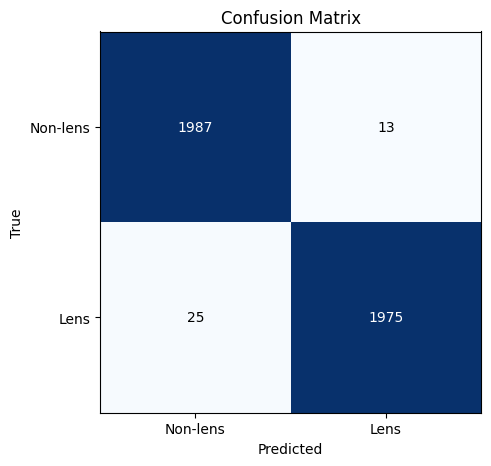

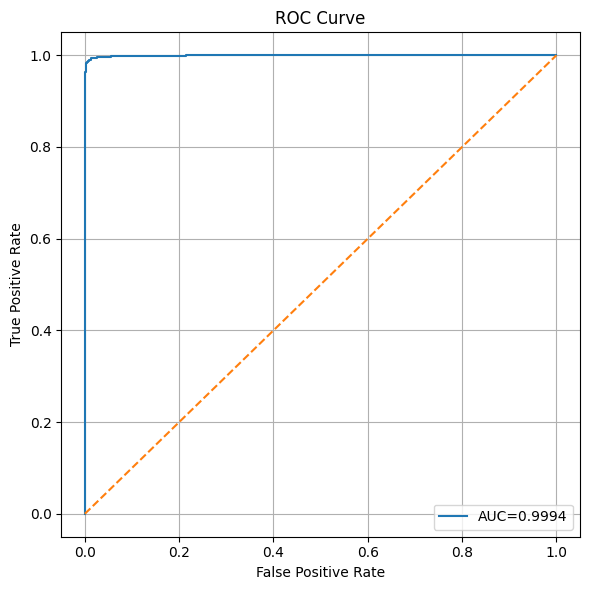

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, roc_auc_score,
    f1_score, precision_score, recall_score, accuracy_score
)

# ROC-based threshold (Youden J)
fpr, tpr, thr = roc_curve(all_labels, all_probs)
best_t = thr[np.argmax(tpr - fpr)]
preds = (all_probs >= best_t).astype(int)

acc = accuracy_score(all_labels, preds)
prec = precision_score(all_labels, preds, zero_division=0)
rec = recall_score(all_labels, preds)
f1 = f1_score(all_labels, preds)

try:
    auc = roc_auc_score(all_labels, all_probs)
except ValueError:
    auc = float("nan")

print(f"Best threshold t*: {best_t:.4f}")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1:        {f1:.4f}")
print(f"AUC:       {auc:.4f}\n")

cm = confusion_matrix(all_labels, preds)
print("Confusion Matrix:\n", cm, "\n")

print("Classification Report:\n")
print(classification_report(all_labels, preds, digits=4))

# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0,1], ["Non-lens", "Lens"])
plt.yticks([0,1], ["Non-lens", "Lens"])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center", color="white" if v > cm.max()/2 else "black")
plt.tight_layout()
plt.show()

# Plot ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Radius MAE:  0.0686
Radius RMSE: 0.1031
Radius R^2:  0.8610
Residual mean: 0.0201 | std: 0.1011


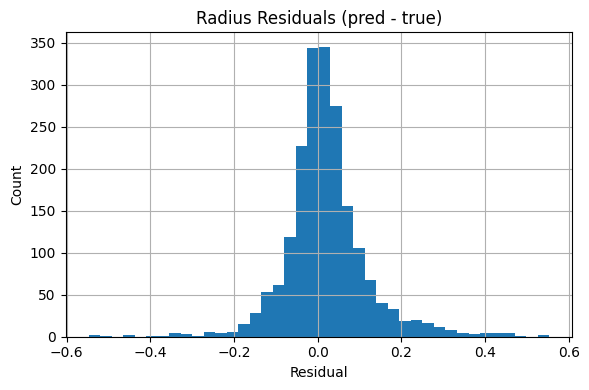

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

if len(all_r_true_phys) == 0:
    print("No y=1 samples found for radius evaluation.")
else:
    mae  = mean_absolute_error(all_r_true_phys, all_r_pred_phys)
    rmse = np.sqrt(mean_squared_error(all_r_true_phys, all_r_pred_phys))
    r2   = r2_score(all_r_true_phys, all_r_pred_phys)

    resid = all_r_pred_phys - all_r_true_phys

    print(f"Radius MAE:  {mae:.4f}")
    print(f"Radius RMSE: {rmse:.4f}")
    print(f"Radius R^2:  {r2:.4f}")
    print(f"Residual mean: {resid.mean():.4f} | std: {resid.std():.4f}")

    # Residual histogram
    plt.figure(figsize=(6,4))
    plt.hist(resid, bins=40)
    plt.title("Radius Residuals (pred - true)")
    plt.xlabel("Residual")
    plt.ylabel("Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

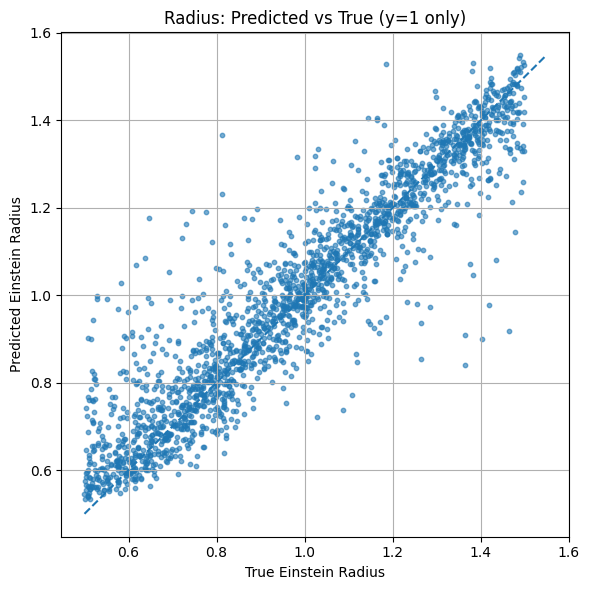

In [10]:
if len(all_r_true_phys) == 0:
    print("No y=1 samples found for radius evaluation.")
else:
    mn = min(all_r_true_phys.min(), all_r_pred_phys.min())
    mx = max(all_r_true_phys.max(), all_r_pred_phys.max())

    plt.figure(figsize=(6,6))
    plt.scatter(all_r_true_phys, all_r_pred_phys, s=10, alpha=0.6)
    plt.plot([mn, mx], [mn, mx], linestyle="--")  # y=x line
    plt.xlabel("True Einstein Radius")
    plt.ylabel("Predicted Einstein Radius")
    plt.title("Radius: Predicted vs True (y=1 only)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

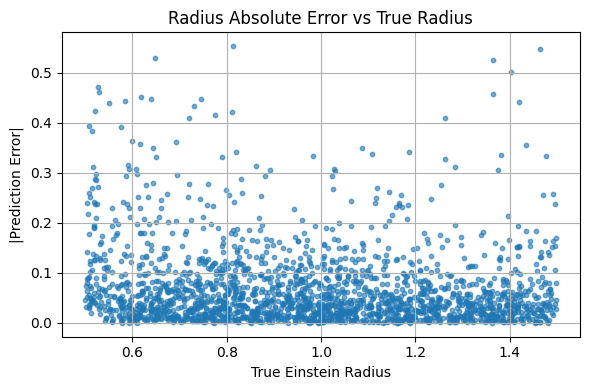

In [11]:
if len(all_r_true_phys) == 0:
    print("No y=1 samples found for radius evaluation.")
else:
    abs_err = np.abs(all_r_pred_phys - all_r_true_phys)

    plt.figure(figsize=(6,4))
    plt.scatter(all_r_true_phys, abs_err, s=10, alpha=0.6)
    plt.xlabel("True Einstein Radius")
    plt.ylabel("|Prediction Error|")
    plt.title("Radius Absolute Error vs True Radius")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [12]:
import numpy as np

r_true = np.array(all_r_true_phys)
r_pred = np.array(all_r_pred_phys)

eps = 1e-8
rel_err = (r_true - r_pred) / (np.abs(r_true) + eps)

print("Relative error stats:")
print(f"  mean: {rel_err.mean():.4f}")
print(f"  std : {rel_err.std():.4f}")
print(f"  min : {rel_err.min():.4f}")
print(f"  max : {rel_err.max():.4f}")

# optional: percent form
rel_err_pct = 100.0 * rel_err

Relative error stats:
  mean: -0.0356
  std : 0.1300
  min : -0.8938
  max : 0.3847


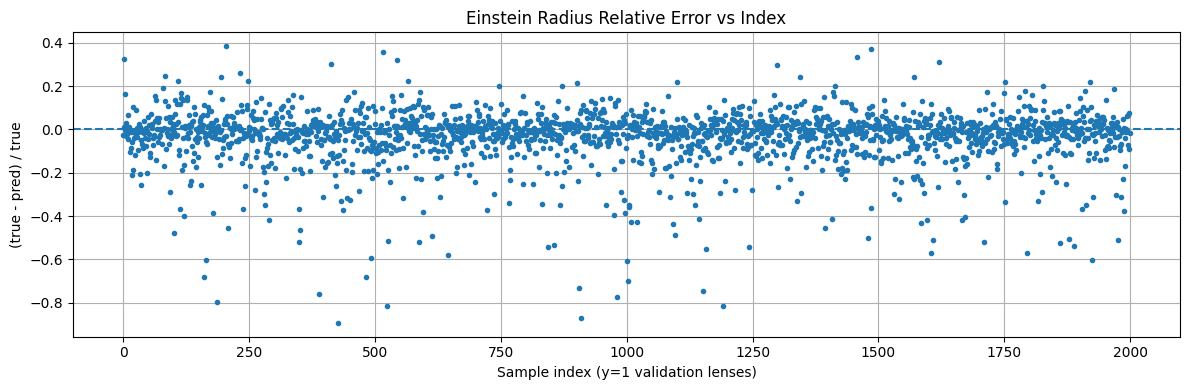

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(rel_err, marker='.', linestyle='None')  # scatter-like
plt.axhline(0.0, linestyle='--')
plt.xlabel("Sample index (y=1 validation lenses)")
plt.ylabel("(true - pred) / true")
plt.title("Einstein Radius Relative Error vs Index")
plt.grid(True)
plt.tight_layout()
plt.show()

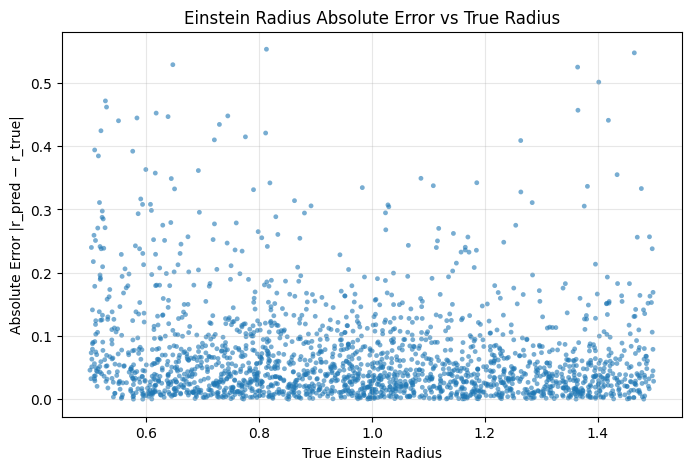

Absolute error stats:
  mean: 0.0686
  std : 0.0770
  min : 0.0001
  max : 0.5531


In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Convert to numpy
r_true = np.array(all_r_true)
r_pred = np.array(all_r_pred)

# If radii were normalized, convert back to physical units
r_true_phys = r_true * r_std + r_mean
r_pred_phys = r_pred * r_std + r_mean

abs_err = np.abs(r_pred_phys - r_true_phys)

plt.figure(figsize=(8, 5))
plt.scatter(
    r_true_phys,
    abs_err,
    s=12,
    alpha=0.6,
    edgecolor="none"
)

plt.xlabel("True Einstein Radius")
plt.ylabel("Absolute Error |r_pred − r_true|")
plt.title("Einstein Radius Absolute Error vs True Radius")
plt.grid(True, alpha=0.3)

plt.show()

# ---- stats ----
print("Absolute error stats:")
print(f"  mean: {abs_err.mean():.4f}")
print(f"  std : {abs_err.std():.4f}")
print(f"  min : {abs_err.min():.4f}")
print(f"  max : {abs_err.max():.4f}")

In [15]:
theta_e = np.load(os.path.join(path, "theta_Es.npy"))

print(f"theta_E min : {theta_e.min():.4f}")
print(f"theta_E max : {theta_e.max():.4f}")
print(f"theta_E mean: {theta_e.mean():.4f}")
print(f"theta_E std : {theta_e.std():.4f}")

theta_E min : 0.0000
theta_E max : 1.4999
theta_E mean: 0.4884
theta_E std : 0.5257
